## Genetic algorithm for recreation of target images  
This project uses a genetic algorithm to approximate the loaded original image by drawing the image through several triangles. In nature, the individual appearance of living things is largely determined by the genes on the chromosomes. Similarly, if we consider something made of triangles as an individual, the appearance of that individual is determined by the position and colour of the triangles that make it up. The triangles can be identified as the "genes" of the individual. This "gene" gradually approaches the ideal original image through genetic processes such as selection, crossover and mutation. The main processes of the genetic algorithm are described below.  
ref: https://www.zhihu.com/tardis/zm/art/149710617?source_id=1003    
https://medium.com/@sebastian.charmot/genetic-algorithm-for-image-recreation-4ca546454aaa  
https://alteredqualia.com/visualization/evolve/

In [ ]:
import copy
import random
import torch
import numpy as np
from PIL import Image, ImageDraw

The genetic algorithm consists of several components:


*   init population
*   fitness function
*   selection
*   crossover
*   mutation

We encode triangles with three pairs of numbers, each pair corresponding to a vertex of the triangle; we encode colours with four pairs of numbers (RGBA) in the range (0, 256).

For initial population, we generate random integer coordinates within the range [0, w) for the x-coordinate and [0, h) for the y-coordinate. The coordinates are generated for 3 points, forming a 3x2 array.
It generates random RGBA values within the range [0, 256) for each color channel (red, green, blue, alpha), then we repeat the following procedures  

**input**:$N_{p-size}, T_{iters}, N_3, img$  
$P \leftarrow random\_population(N)$  
$while$ $t$  $\leq$ $T$ $do$  
$t$ $\leftarrow$  $ t + 1 $  
$P \leftarrow $ mutation(P)  
$P \leftarrow  evalution(P, img)_{best}$  
$end$ $while$





In [ ]:
def get_random_individual(obj_num, w, h, device):
    random_individual = []
    for _ in range(obj_num):
        cords = torch.randint(low=0, high=w, size=(3, 2), dtype=torch.int, device=device)
        RGBA = torch.randint(256, size=(4,), dtype=torch.int, device=device)
        random_individual.append((cords, RGBA))
    return random_individual

def get_random_population(obj_num, N, w, h, device):
    return [get_random_individual(obj_num, w, h, device) for _ in range(N)]


For the evaluation of a single individual, we generate an image from an individual, then we calculate the mean squared error between the image generated by the individual and the target image. It sums the squared differences between corresponding elements of the two tensors, then divides by the total number of elements in the tensors to compute the mean squared error. It can be formulated as:  
$data$ - generated image by individual, $input\_data$ - target image, denote the dimension of the images as $width*height$  
$$MSE = {\frac{1}{width * height}}{\sum_{i=1}^{width}}{\sum_{j=1}^{height}(data[i,j]-input\_data[i,j])^2}$$  
$$fitness\_value = MSE$$



In [ ]:
def draw(cords, RGBA, drw):
    cords = list(map(tuple, cords.cpu().numpy()))
    RGBA[3] = 100
    RGBA = tuple(RGBA)
    drw.polygon(cords, RGBA)

def get_img_individual(individual, w, h):
    img = Image.new("RGB", (w, h))
    drw = ImageDraw.Draw(img, 'RGBA')
    for (c, rgb) in individual:
        draw(c, rgb, drw)
    return img, drw

In [ ]:
def fitness(individual, input_data):
    img, _ = get_img_individual(individual, input_data.shape[1], input_data.shape[0])
    data = torch.from_numpy(np.array(img)).type(torch.int32).to(input_data.device)
    return torch.sum((data - input_data) ** 2) / (data.shape[0] * data.shape[1])

In order to explore the solution space for better solutions, we introduce random changes to the coordinates and RGBA values of an individual based on certain probabilitites. In order to speed up the mutation, we introduce the const number as the starting index from which mutations should be applied. Then we generate a binary vector of length 3 with values sampled from a uniform distribution with a probability of 1/3 and another random tensor from normal distribution, then we adjust the x-coordinate  and y-coordiante by adding a portion of the image width and height based on the binary vector and random tensor, we do the same for RGBA, finally we update and return the mutated coordiantes and RGBA values.

In [ ]:
def mutate(indv, const, w, h, device):
    individual = copy.deepcopy(indv)
    for i, (cords, RGBA) in enumerate(individual):
        if i >= const:
            binary_vec = (torch.rand(3) < 1 / 3.0).type(torch.int).to(device)
            random_tensor = torch.randn(3, device=device)
            cords[:, 0] += (binary_vec * (w / 6) * random_tensor).type(torch.int)

            binary_vec = (torch.rand(3) < 1 / 3.0).type(torch.int).to(device)
            random_tensor = torch.randn(3, device=device)
            cords[:, 1] += (binary_vec * (h / 6) * random_tensor).type(torch.int)

            binary_vec = (torch.rand(4) < 1 / 3.0).type(torch.int).to(device)
            random_tensor = torch.randn(4, device=device)
            RGBA += binary_vec * (45 * random_tensor).type(torch.int)

            cords[:, 0] = torch.clamp(cords[:, 0], 0, w)
            cords[:, 1] = torch.clamp(cords[:, 1], 0, h)
            RGBA = torch.clamp(RGBA, 0, 255)

            individual[i] = (cords, RGBA)
    return individual

For the crossover, I have try one-point crossover, ,and Uniform Crossover, by my observation, the Uniform has the best profermance, each gene is inherited from one of the parents with equal probability. This method helps to maintain diversity and can potentially explore a broader solution space.

The children $C_1$ and $C_2$ are formed as:

\
\begin{align*}
C_{1i} &=
\begin{cases}
P_{1i} & \text{if } r_i \leq 0.5 \\
P_{2i} & \text{otherwise}
\end{cases}
\\
C_{2i} &=
\begin{cases}
P_{2i} & \text{if } r_i \leq 0.5 \\
P_{1i} & \text{otherwise}
\end{cases}
\end{align*}


where:
- $P_{1i}$ and $ P_{2i}$ represent the genes at position $i$ in parent 1 and parent 2, respectively.
- $ O_{1i} $ and $ O_{2i}$ represent the genes at position $ i$ in offspring 1 and offspring 2, respectively.
- $r_i $ is a randomly generated number for each gene position $ i $, uniformly distributed between 0 and 1.

This process is repeated for each gene position $ i $ in the chromosome, resulting in two offspring with genetic material inherited randomly from both parents.


In [ ]:
# def crossover(p1, p2):
#     crossover_point = np.random.randint(1, min(len(p1), len(p2)))
#     c1 = p1[:crossover_point] + p2[crossover_point:]
#     c2 = p2[:crossover_point] + p1[crossover_point:]
#     return c1, c2

def crossover(p1, p2):
    child1 = []
    child2 = []
    for gene1, gene2 in zip(p1, p2):
        if np.random.rand() < 0.5:
            child1.append(gene1)
            child2.append(gene2)
        else:
            child1.append(gene2)
            child2.append(gene1)

    return child1, child2

In [ ]:
def update_population(population, diff, w, h, device):
    for i, indv in enumerate(population):
        population[i] += get_random_individual(diff, w, h, device)
    return population

In [ ]:
def evaluate_population(population, img_data, w, h):
    objective_values = [fitness(i, img_data) for i in population]
    population = [population[i] for i, _ in sorted(enumerate(objective_values), key=lambda x: x[1])]
    objective_values.sort()
    return population, objective_values

In the implement stage, we read the input iamge first, then convert it to a tensor for further processing, then we initial parameters and population and start the evolutionary loop.  
In order to speed up the processing, we start with 3 objects, and increases by 1 every 200 iterations, and we compare the difference between new object and current object to decide if add a new object, and we calculate the fitness value for individual and sort them.



In [ ]:
def paint(N, img, output_file_name, T, N_offspring, max_obj_num, device):
    img = Image.open(img)
    img_data = torch.from_numpy(np.asarray(img, dtype=np.int32)).to(device)
    w, h = img.size
    obj_num = 5
    img = Image.new("RGB", (w, h))
    drw = ImageDraw.Draw(img, 'RGBA')
    population = get_random_population(obj_num, N, w, h, device)
    t = 0
    gif = []

    constant_obj = 0
    iters  = []
    fitnesses = []
    while t < T:
        new_obj_num = min(int(t / 200) + 3, max_obj_num) # change 3 triangles
        diff = new_obj_num - obj_num
        if diff > 0:
            population = update_population(population, diff, w, h, device)
            obj_num = new_obj_num
            constant_obj = obj_num - 3

        population, objective_values = evaluate_population(population, img_data, w, h)

        if t % 100 == 0: # gif
            best_fitness = objective_values[0]
            num_poly = len(population[0])
            img, drw = get_img_individual(population[0], w, h)
            drw.text((0, 0),
                      'iterations: {}\nfitness: {}\ntriangles: {}'.format(t, best_fitness, num_poly),
                      fill="white")
            print(f'iters:{t}  fitness:{best_fitness}  triangles:{num_poly}')
            gif.append(img)

        old_population = copy.deepcopy(population)
        old_objective_values = copy.deepcopy(objective_values)

        population = []

        for i in range(N):
            for j in range(N_offspring):
                if len(population) >= N_offspring:
                    child1, child2 = crossover(population[j], population[np.random.randint(len(population))])
                    population.append(mutate(child1, constant_obj, w, h, device))
                    population.append(mutate(child2, constant_obj, w, h, device))
                else:
                    population.append(get_random_individual(obj_num, w, h, device))
        objective_values = [fitness(i, img_data) for i in population]
        population = [population[i] for i, _ in sorted(enumerate(objective_values), key=lambda x: x[1])]
        objective_values.sort()

        objective_values.extend(old_objective_values)
        population.extend(old_population)

        population = [population[i] for i, _ in sorted(enumerate(objective_values), key=lambda x: x[1])]

        population = population[:N]
        t += 1

    img, drw = get_img_individual(population[0], w, h)  # best individual
    img.save(output_file_name + '.png', quality='keep')
    display(img)
    gif[0].save(output_file_name + '.gif', format='GIF', append_images=gif[1:], save_all=True, duration=4, loop=0)

In [ ]:
! gdown https://raw.githubusercontent.com/wenjie-hoo/Uni_stuff/main/Evolutionary_Algorithm/project/imgs/Girl-with-a-Pearl.jpg

Downloading...
From: https://raw.githubusercontent.com/wenjie-hoo/Uni_stuff/main/Evolutionary_Algorithm/project/imgs/Girl-with-a-Pearl.jpg
To: /content/Girl-with-a-Pearl.jpg
100% 216k/216k [00:00<00:00, 3.69MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paint(N=10, img='./Girl-with-a-Pearl.jpg', output_file_name='girl', T=10000, N_offspring=20, max_obj_num=50, device=device)

iters:0  fitness:28019.193359375  triangles:5


KeyboardInterrupt: 

<div style="display: flex; flex-wrap: wrap;">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_5.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_10.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_15.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_20.jpg" width="150">
</div>
<div style="display: flex; flex-wrap: wrap;">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_25.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_30.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_35.jpg" width="150">
    <img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl_42.jpg" width="150">
</div>


Unfortunately, because of the long run time, it is difficult to obtain data to compare the final results for different parameters, as shown below for a small number of iterations.  
<img src="https://github.com/wenjie-hoo/Uni_stuff/blob/main/Evolutionary_Algorithm/project/imgs/n1nc10.jpg?raw=true" width="400">




Due to the lack of computer performance could not adjust the parameter settings to a larger size, we show the results of 30,000 iterations with a population size $N$ of 1 and a child's size of 2. In the end, the programme produced 202 triangles, and due to the scale child's size size is too small, the final result lost a lot of details, especially the details of the face.

<img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/girl.png" width="300">
<img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/Girl-with-a-Pearl.jpg" width="300">



Larger population and offspring are currently still running. Currently, more than 70 triangles are generated, and the MSE is below 1000. From this, it can be judged that the final result generated by the program should be good, and the details of the recreation characters should be much richer. , in short, the final result picture will be attached after the program is completed.

<img src="https://github.com/wenjie-hoo/Uni_stuff/raw/main/Evolutionary_Algorithm/project/imgs/N10NC30-30k_iters.jpg" width="300">


Try it on another picture

In [ ]:
! gdown https://upload.wikimedia.org/wikipedia/commons/5/5d/Eug%C3%A8ne_Delacroix_-_Le_28_Juillet._La_Libert%C3%A9_guidant_le_peuple.jpg

t: 0 fitness: 23611.212413503126 triangles: 5


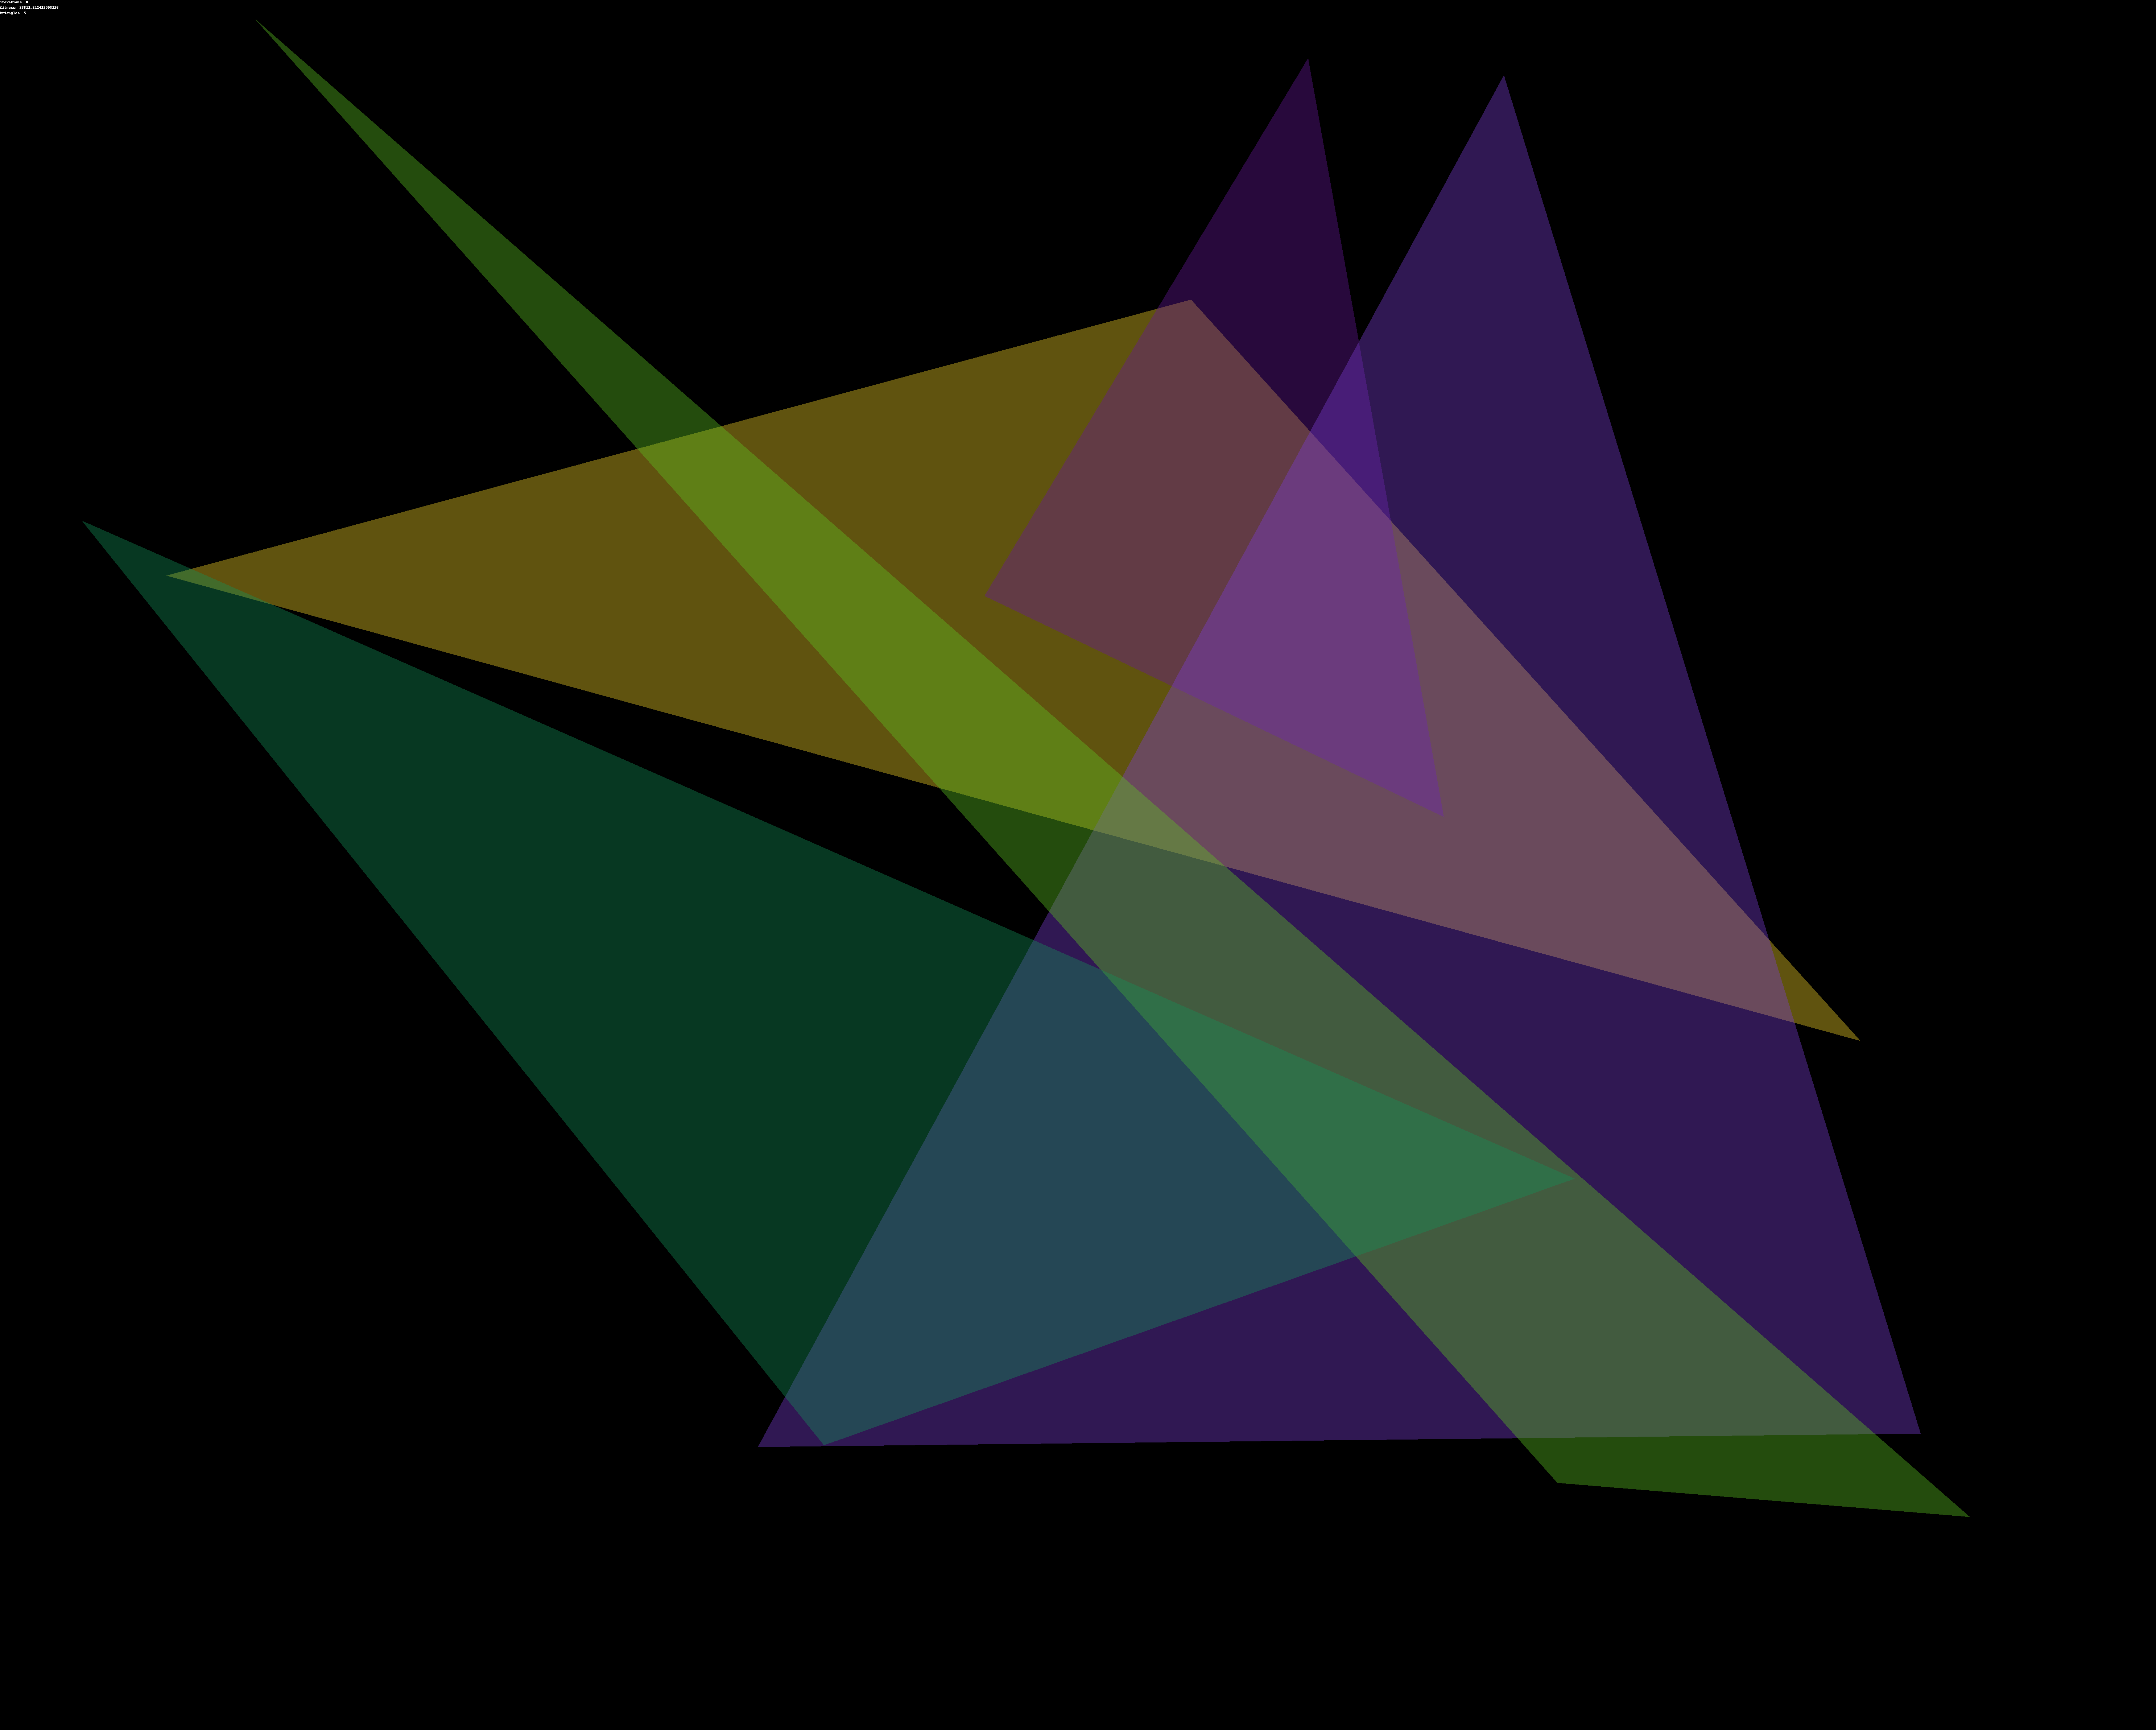

t: 100 fitness: 9338.575202216442 triangles: 5


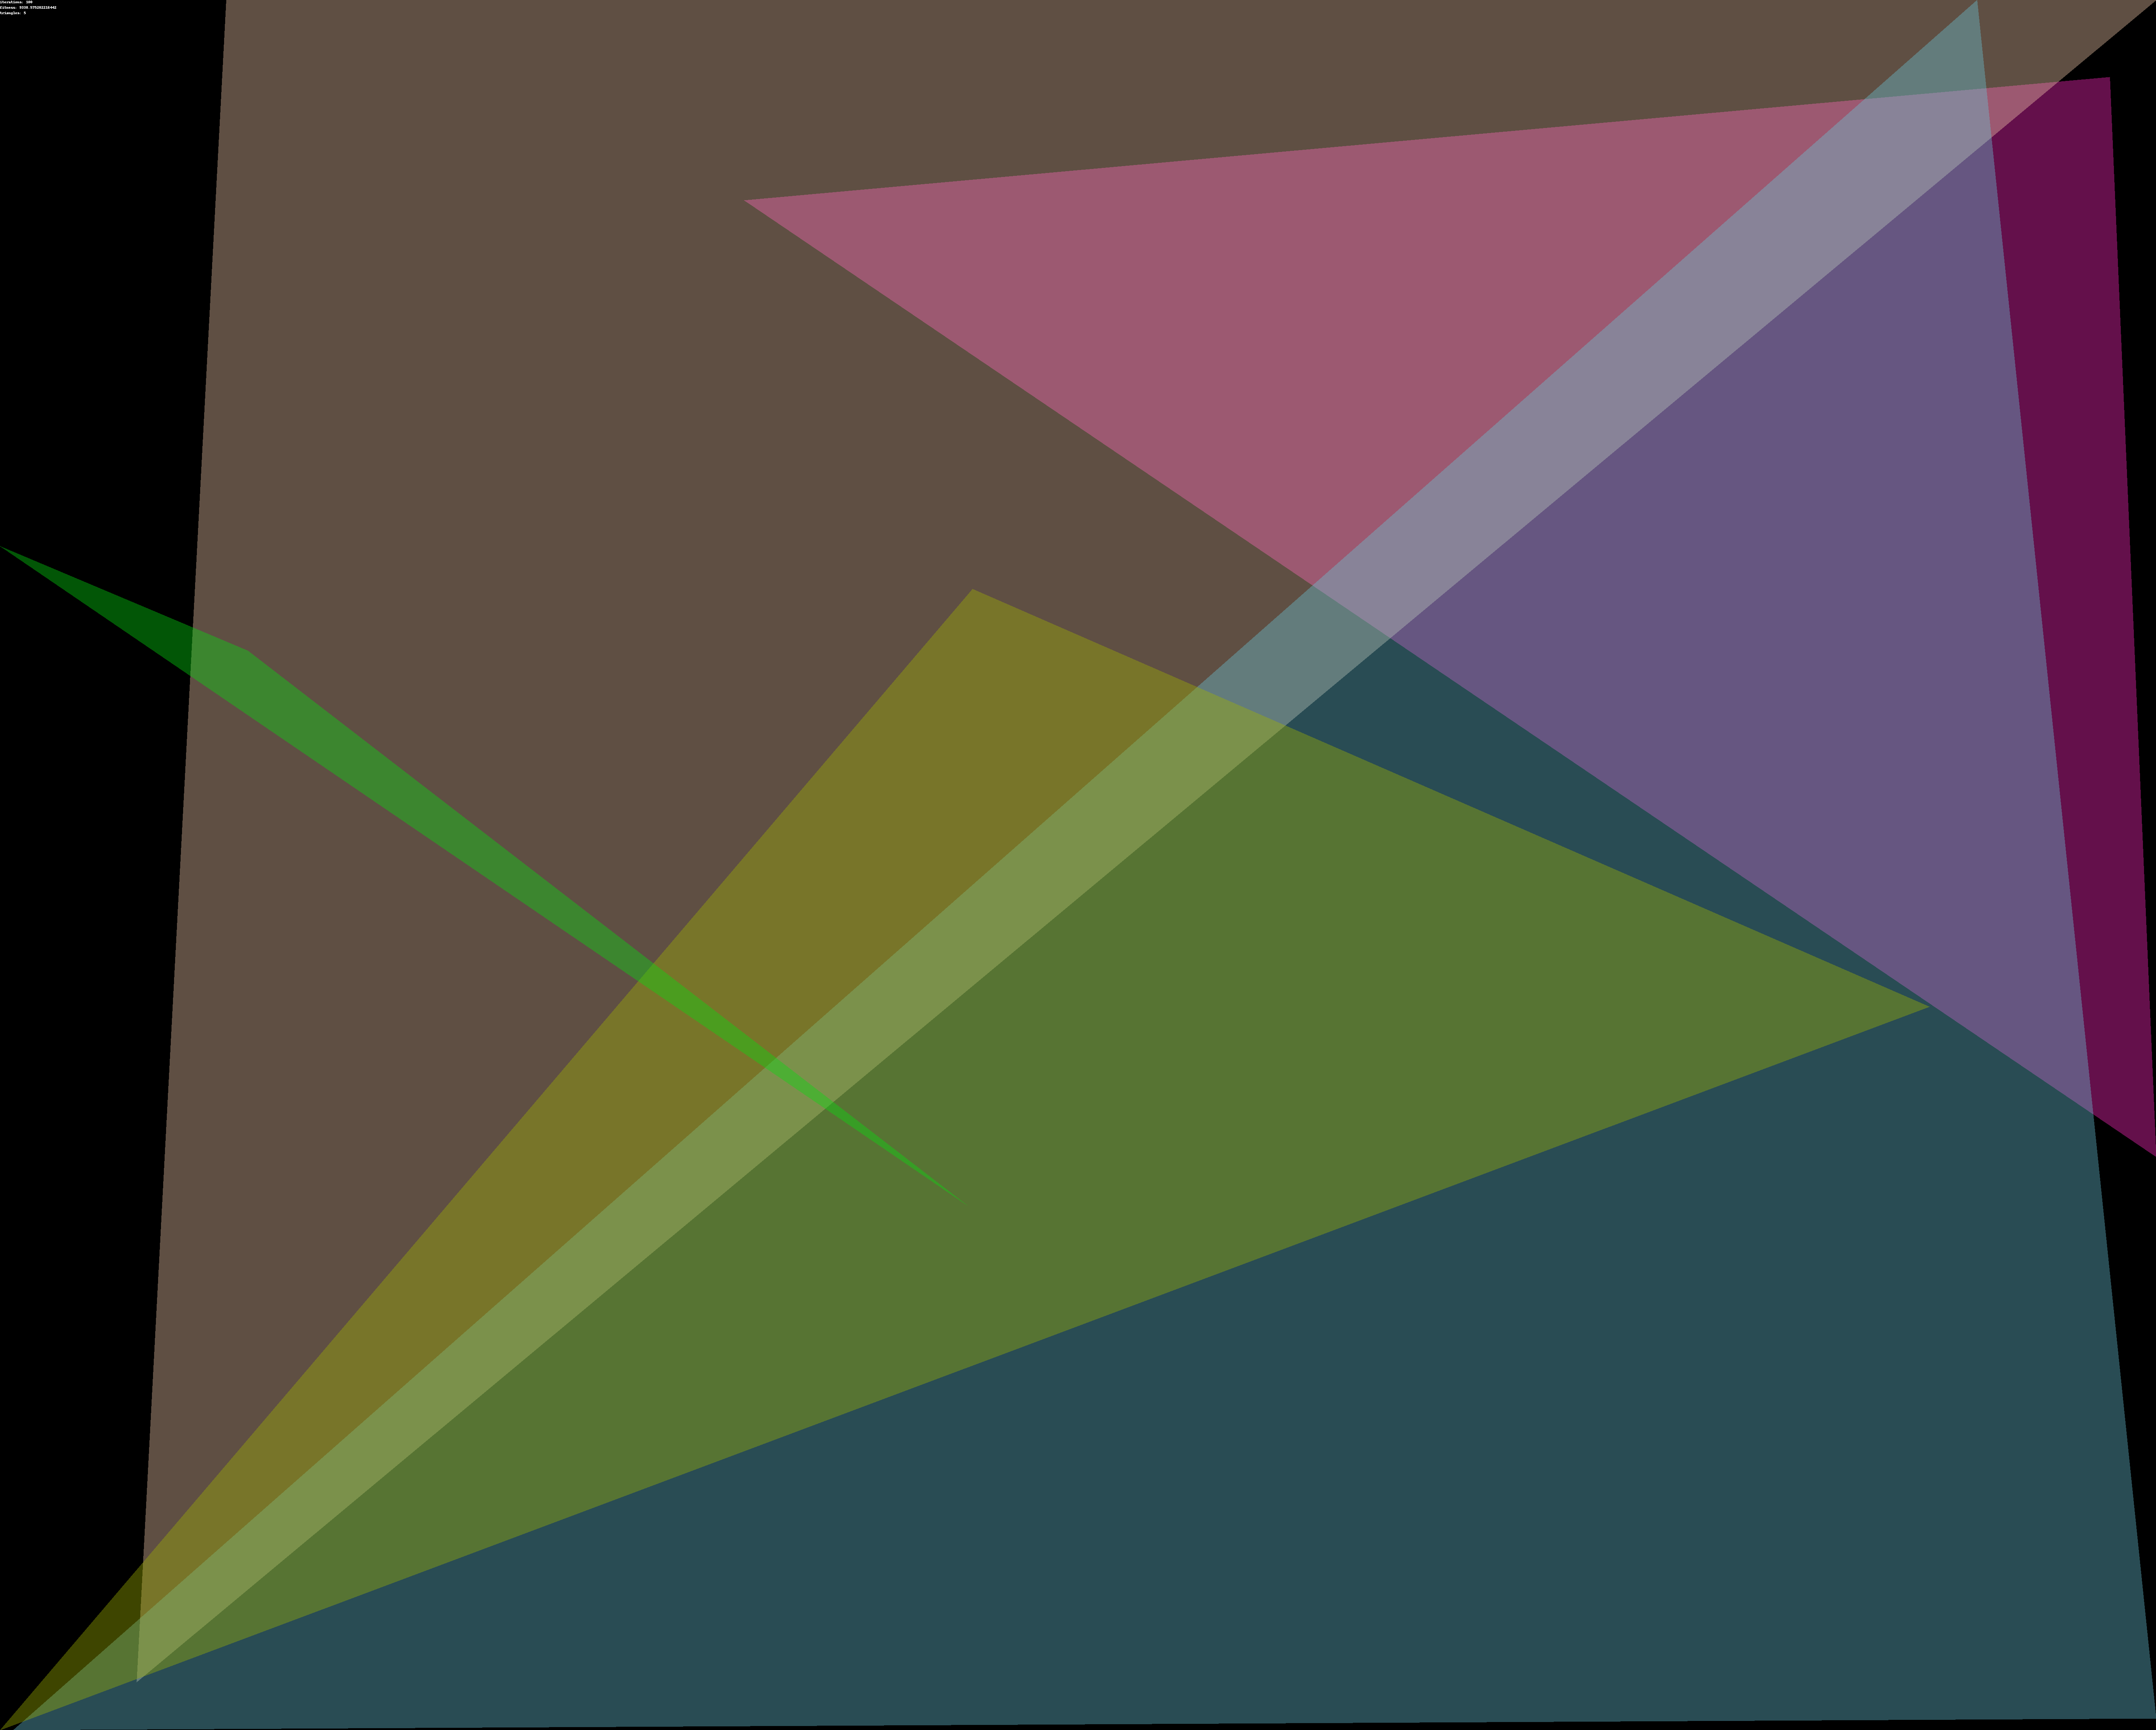

t: 200 fitness: 7049.809041698066 triangles: 7


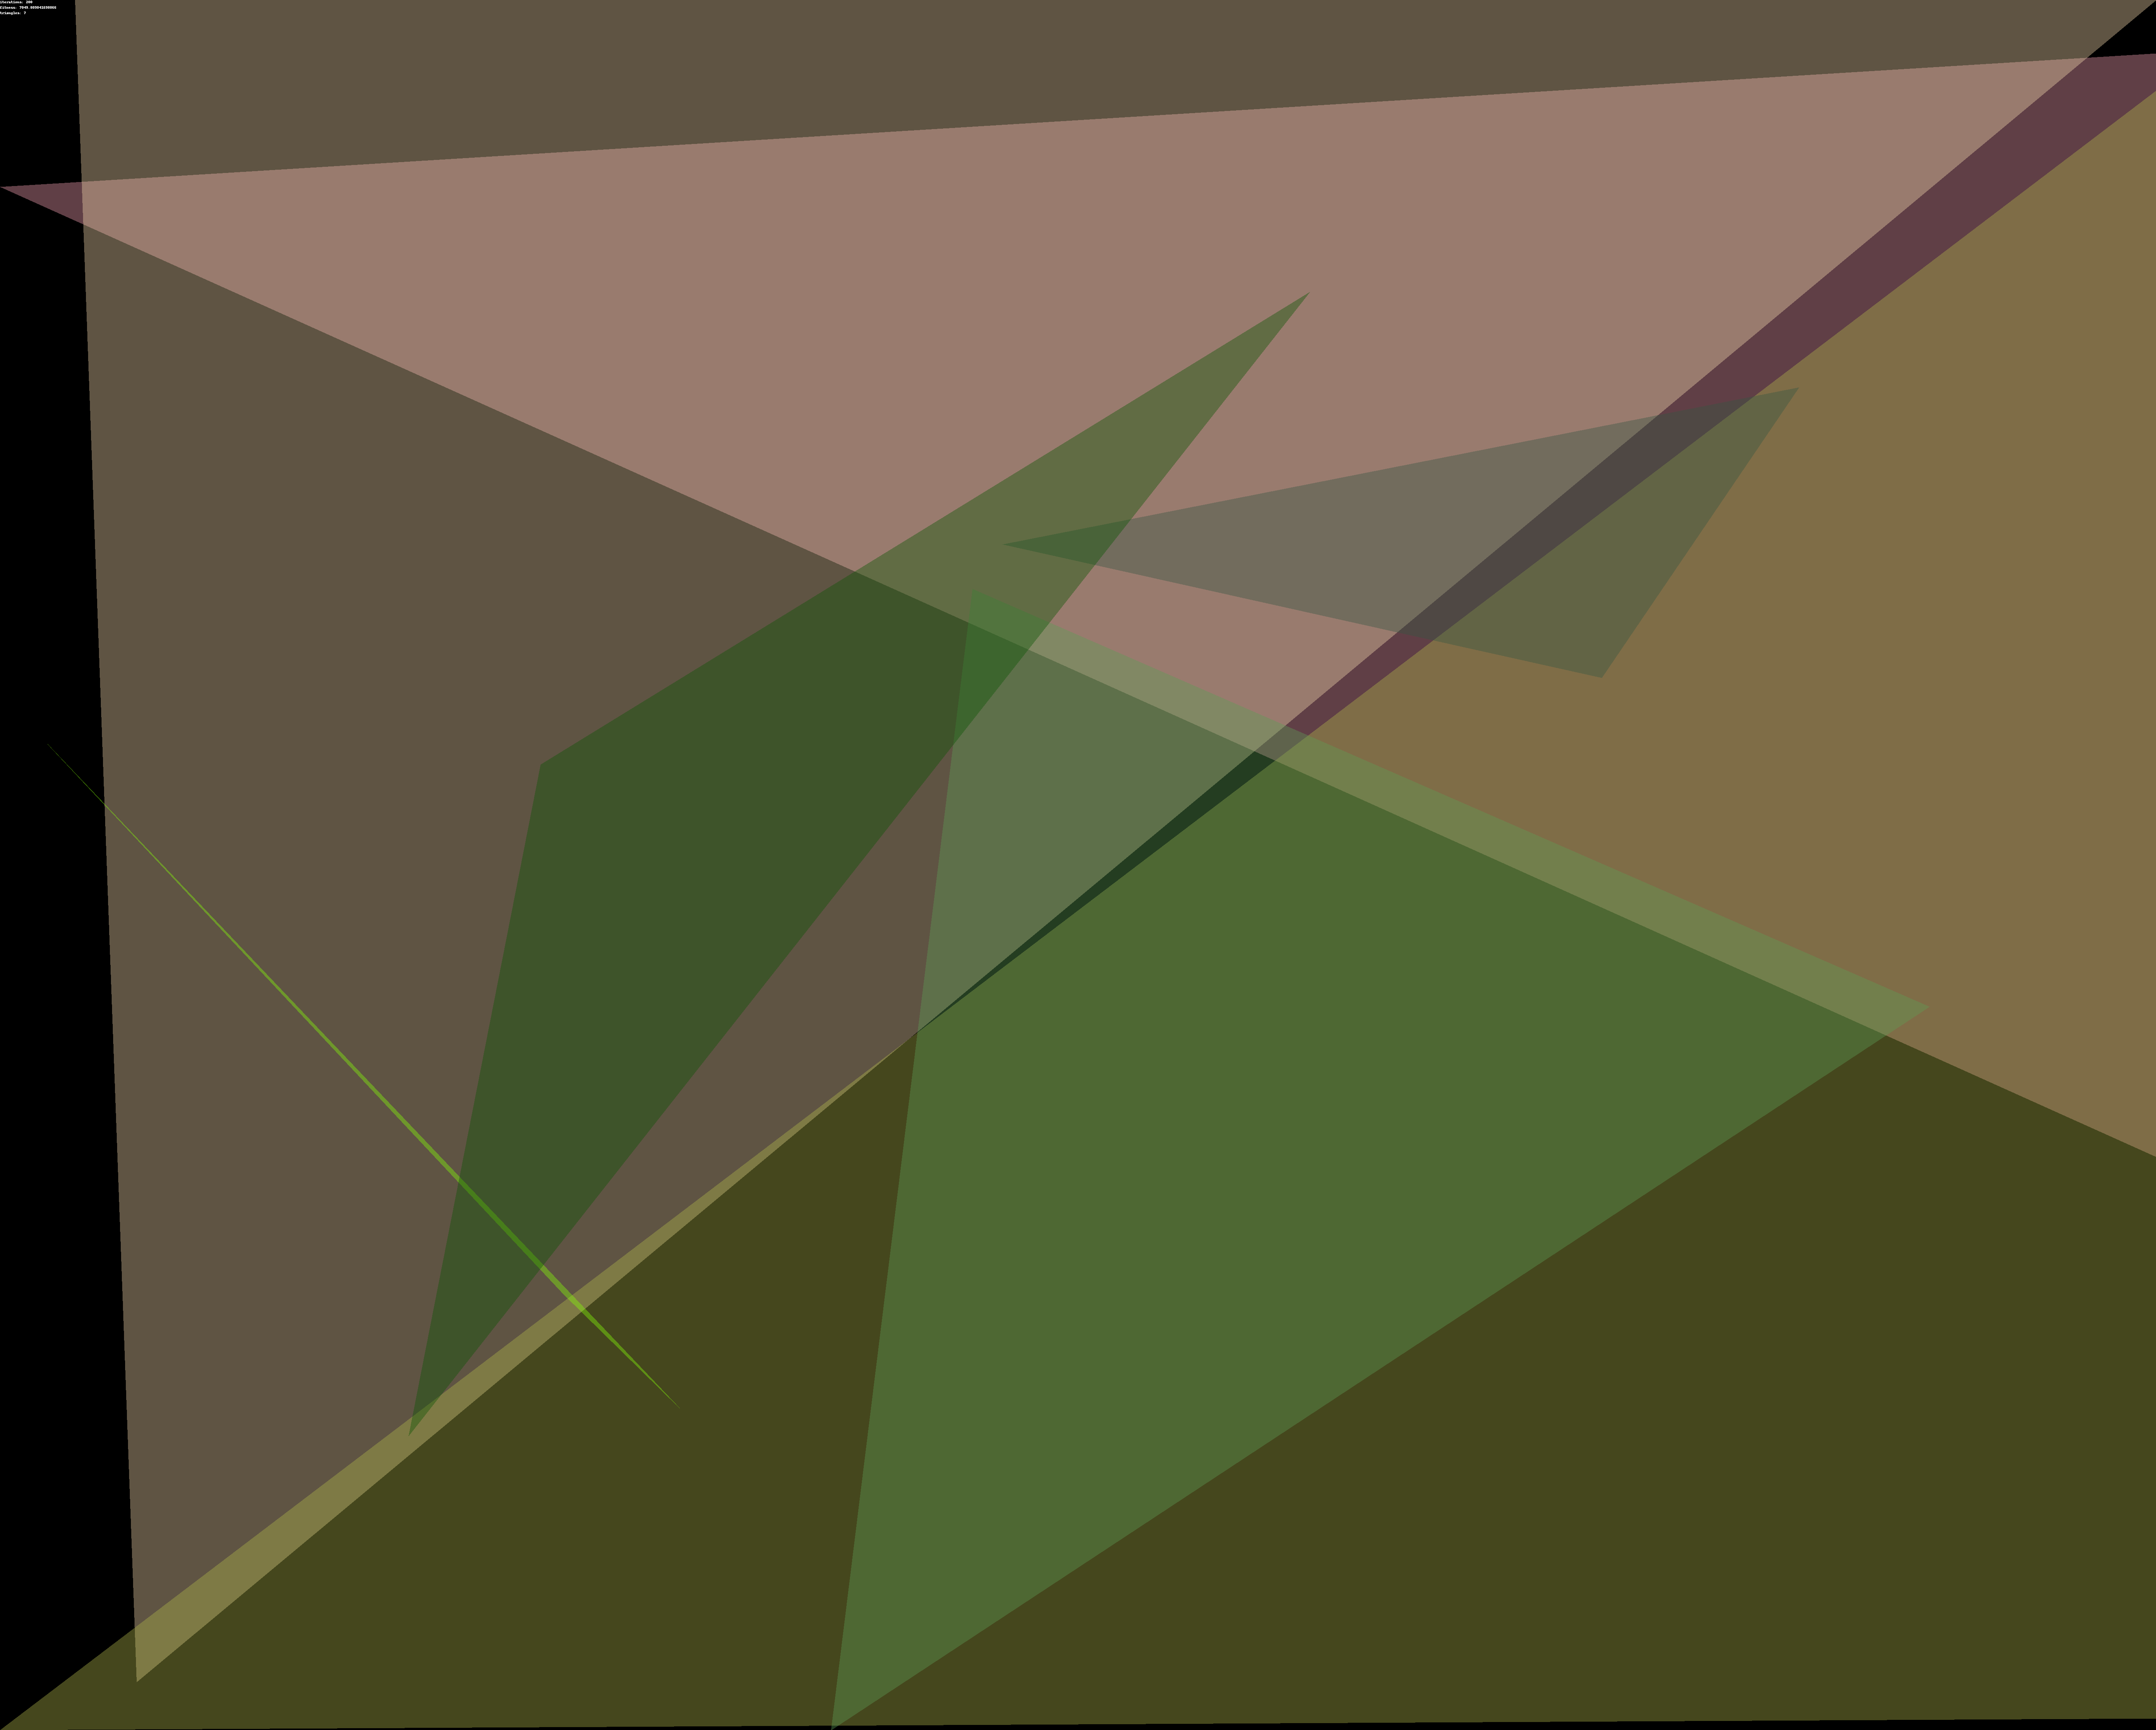

t: 300 fitness: 6481.886465473549 triangles: 9


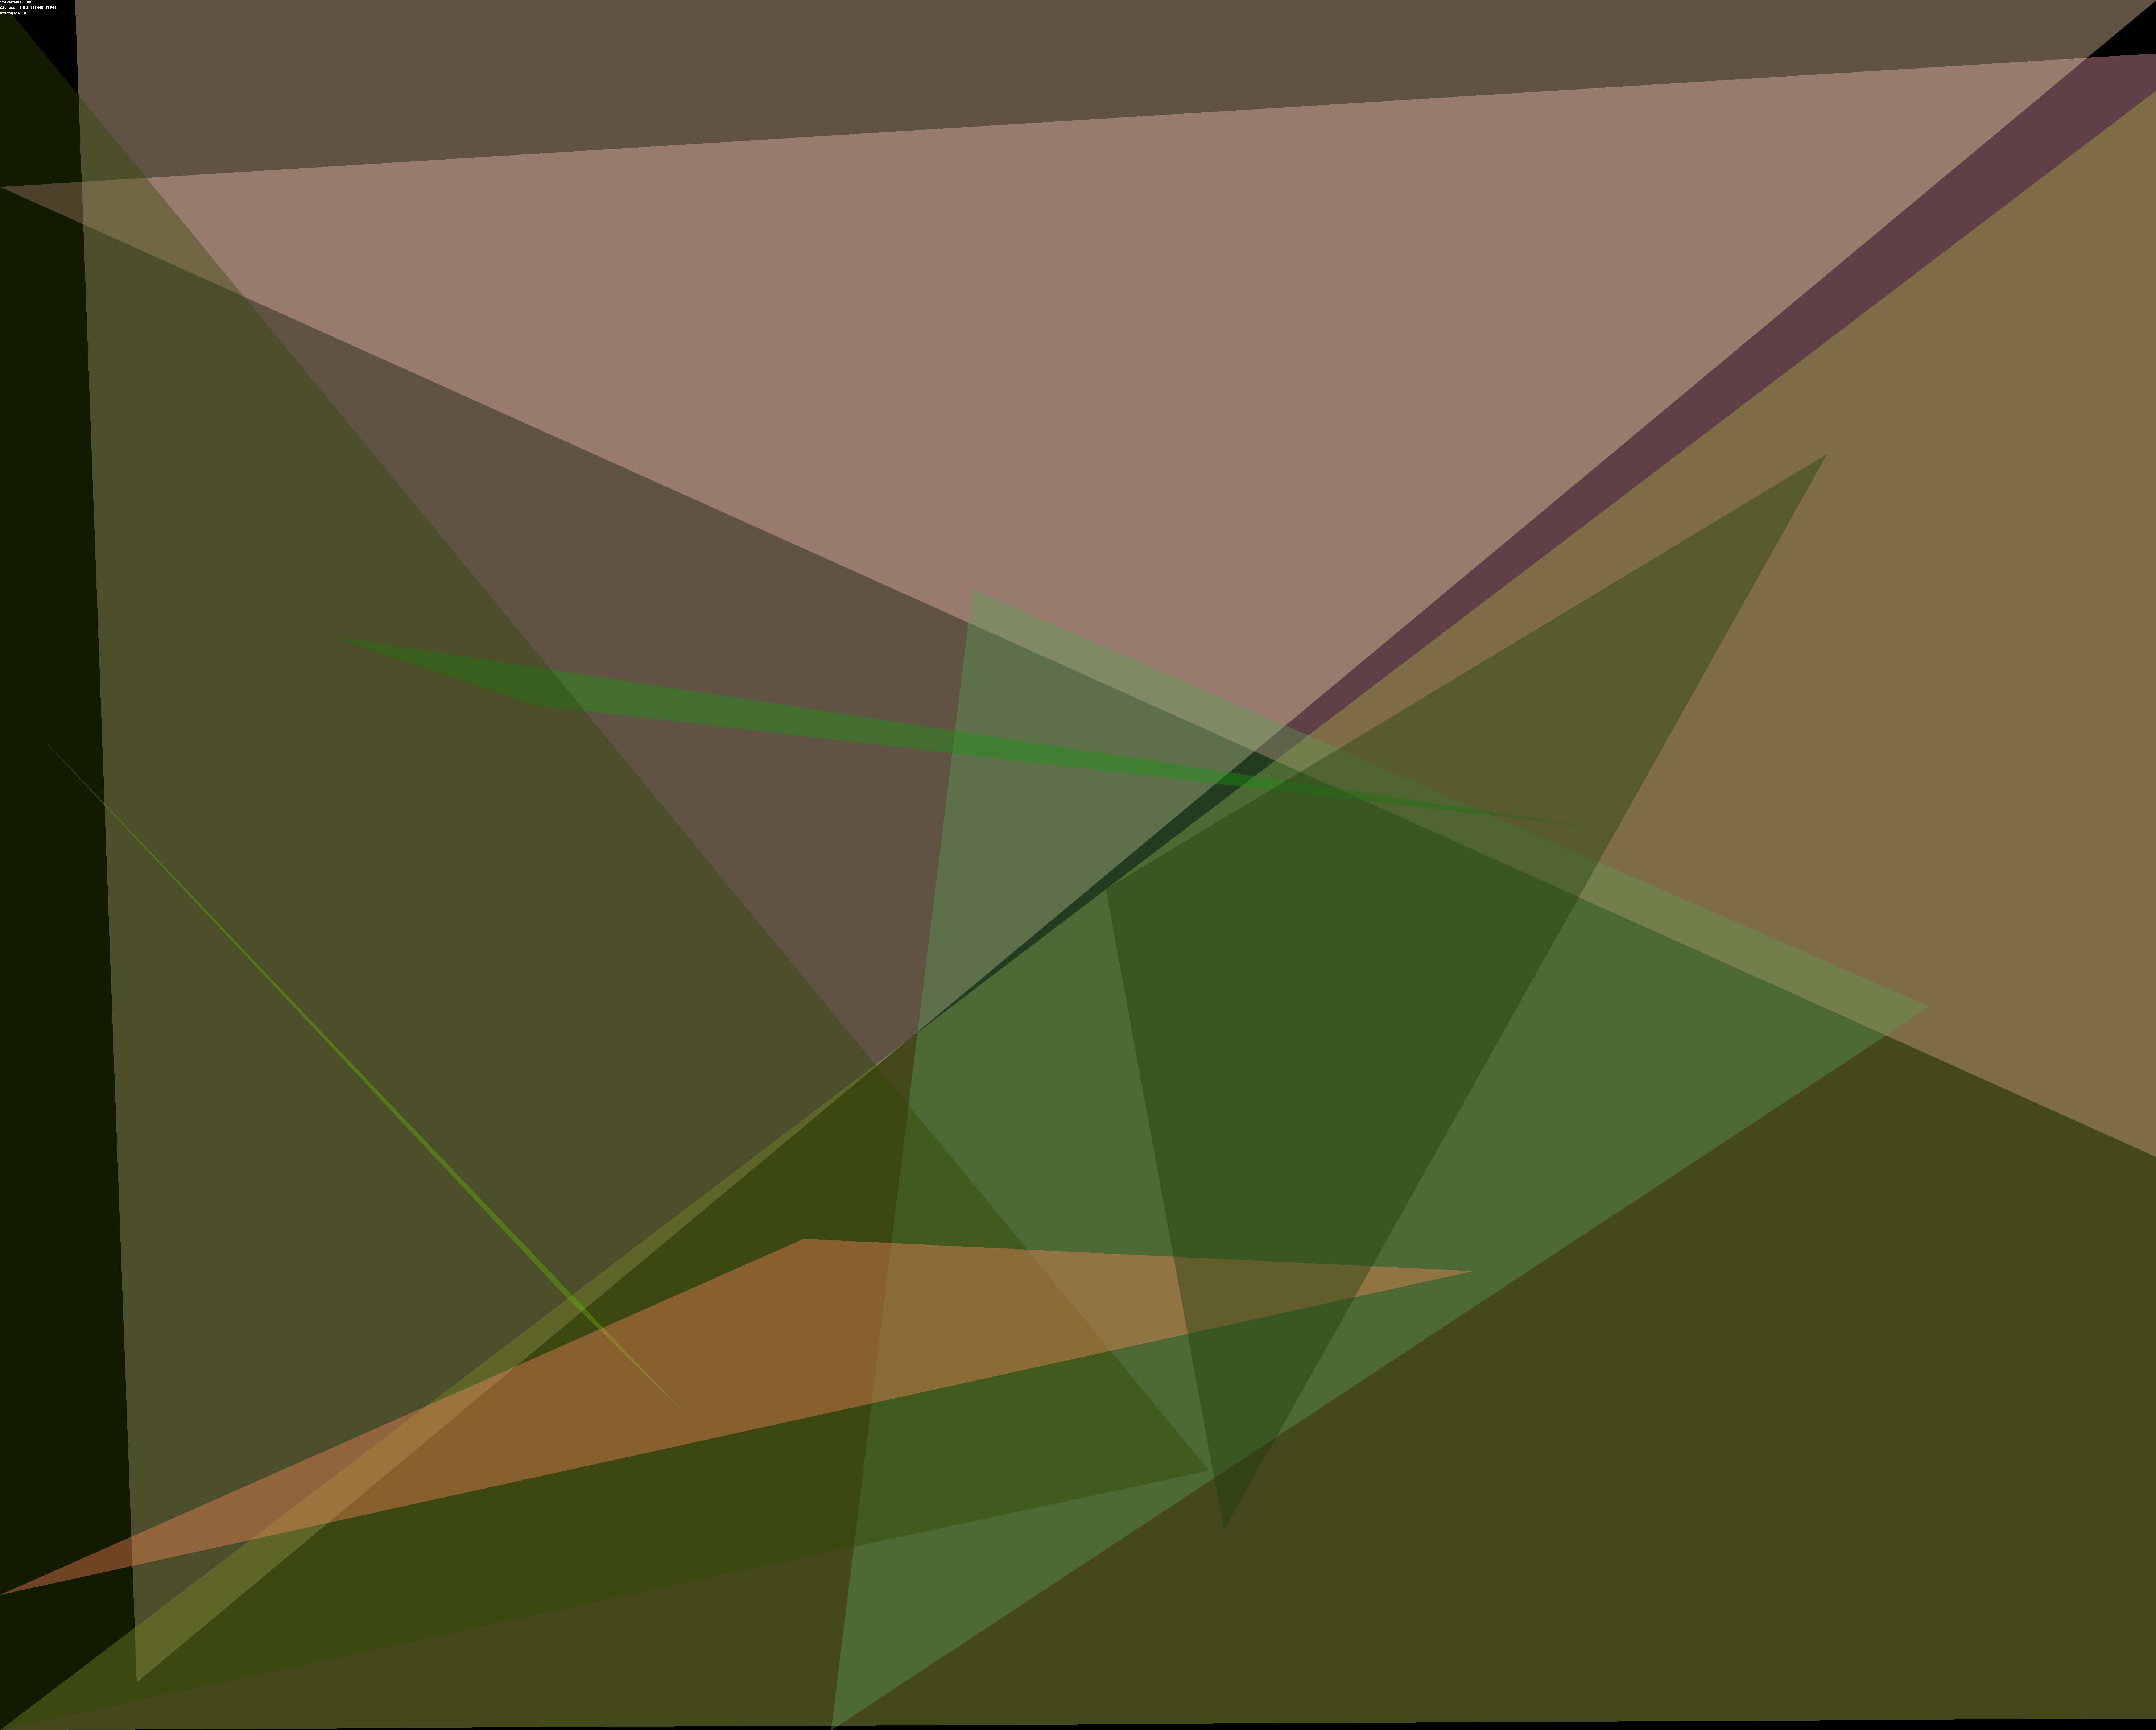

t: 400 fitness: 6599.997876366936 triangles: 11


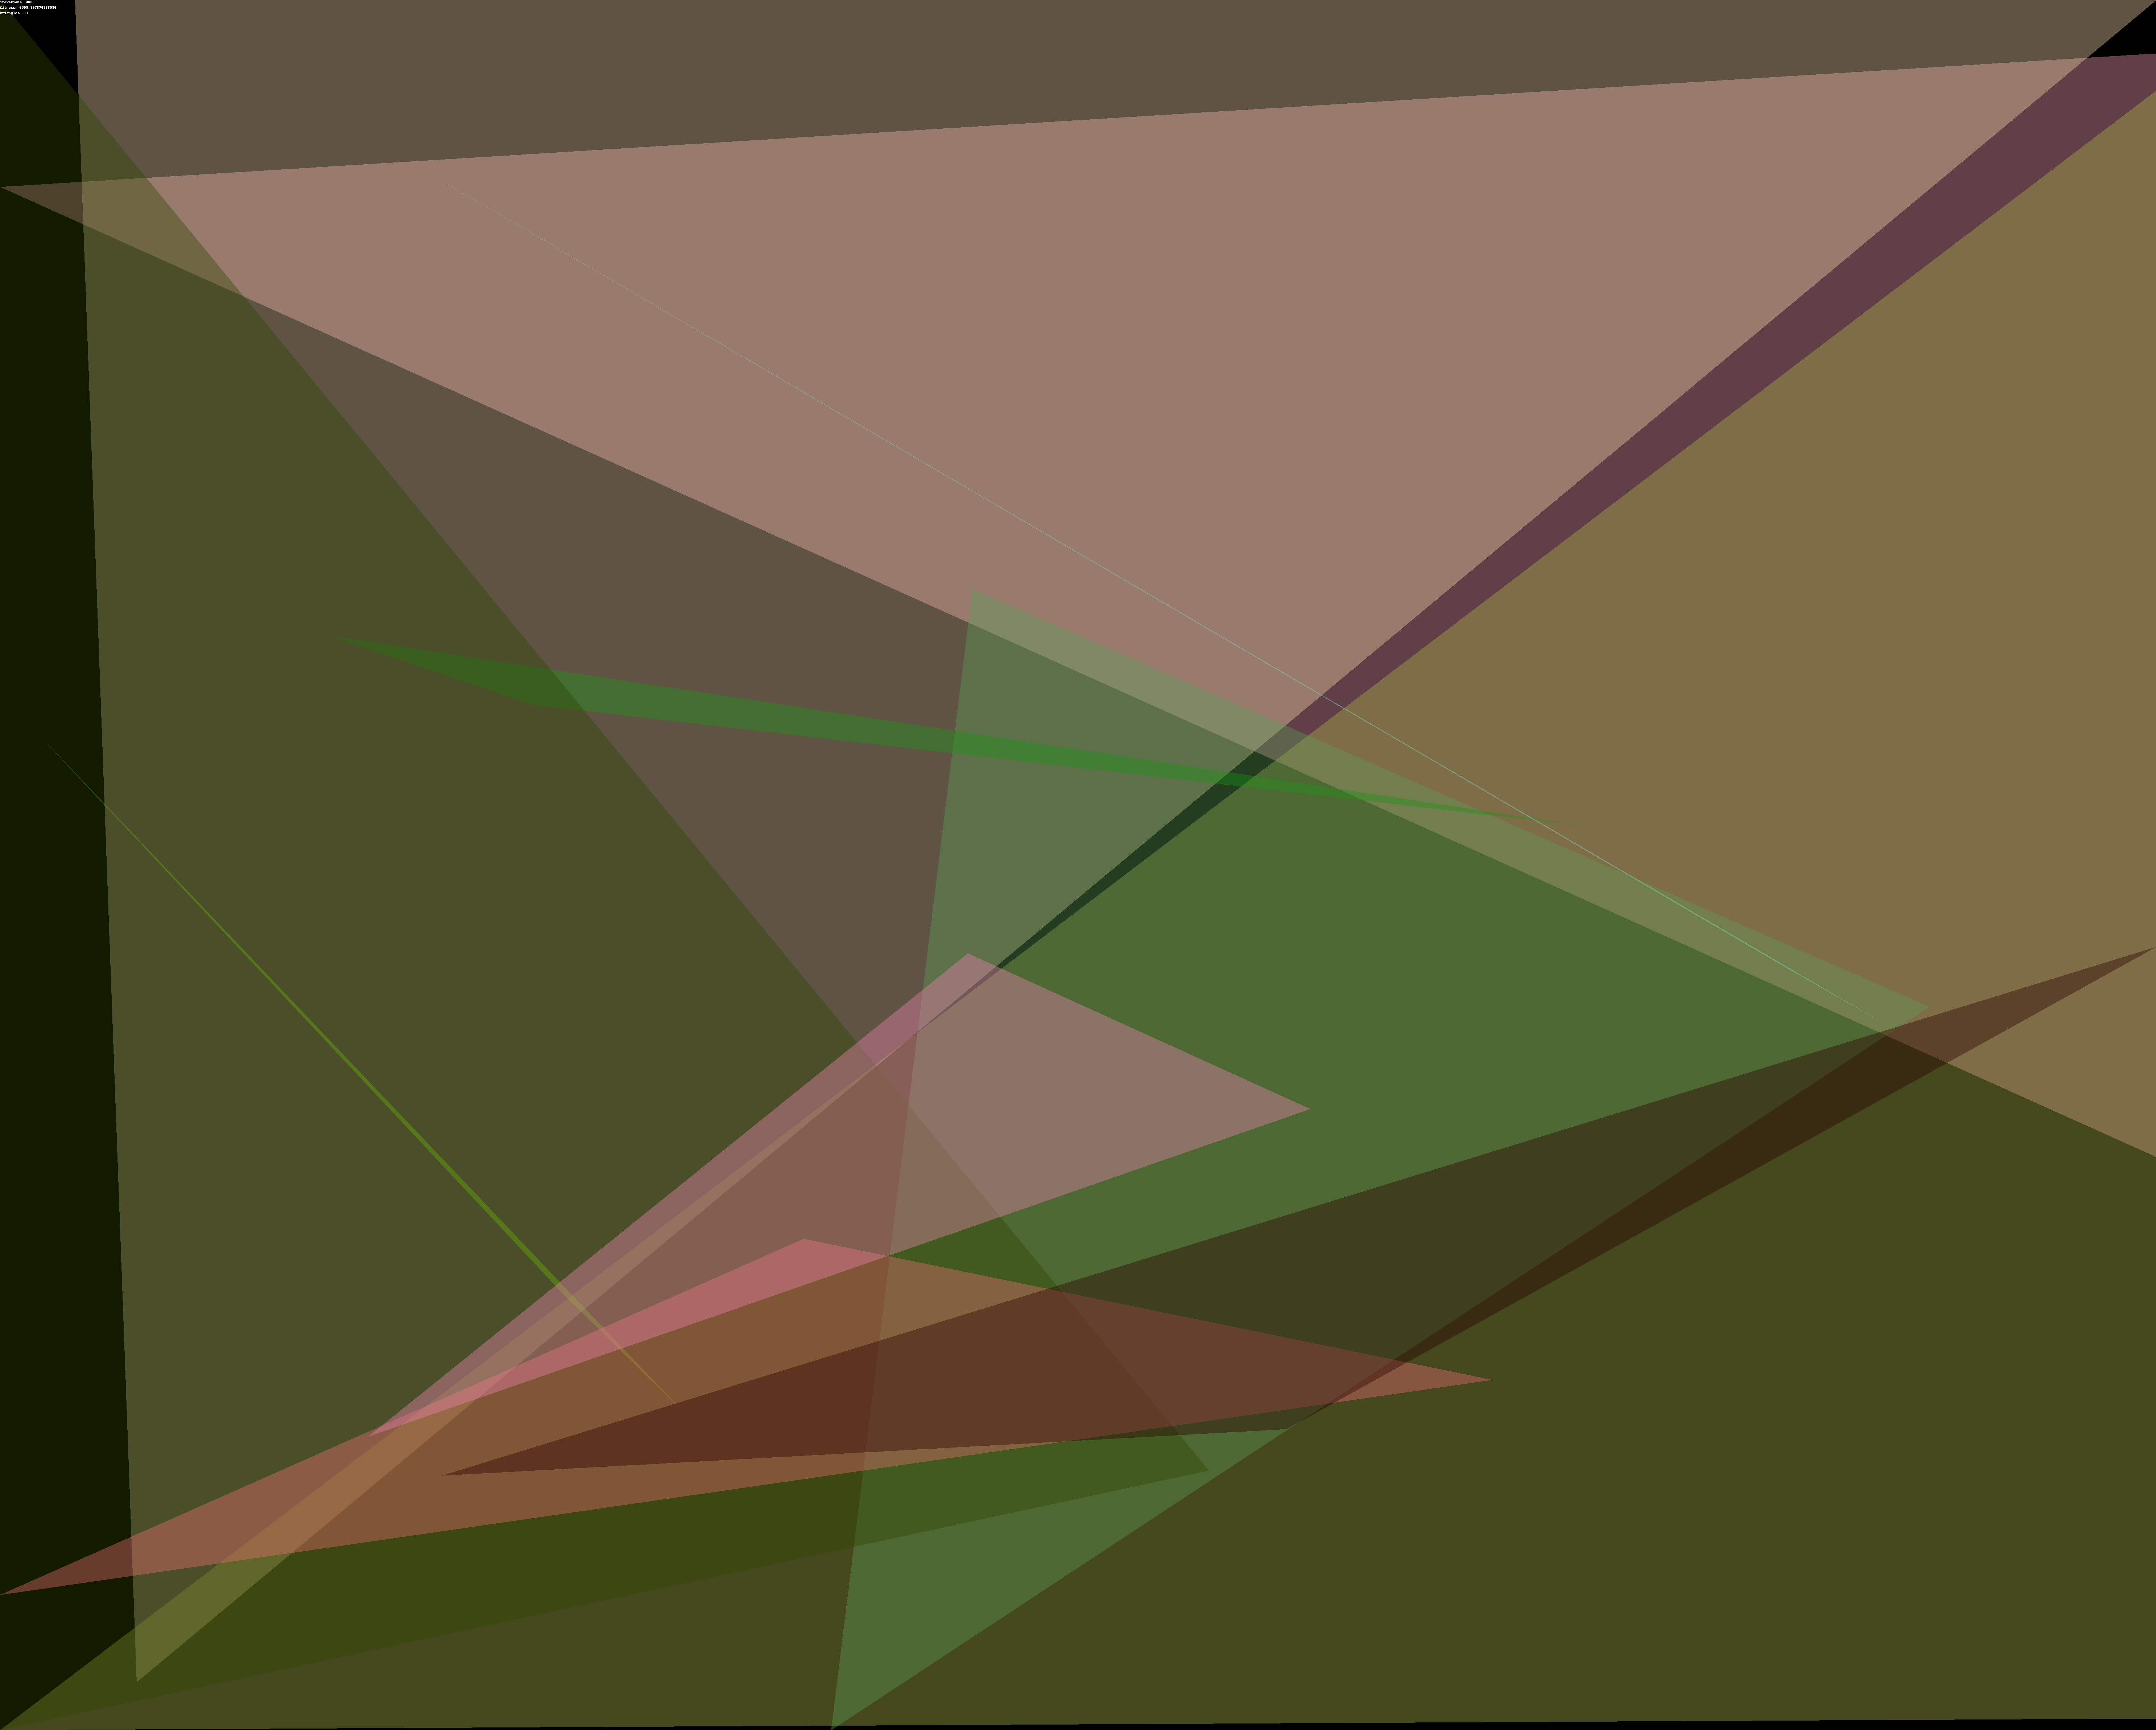

t: 500 fitness: 6366.52479917243 triangles: 13


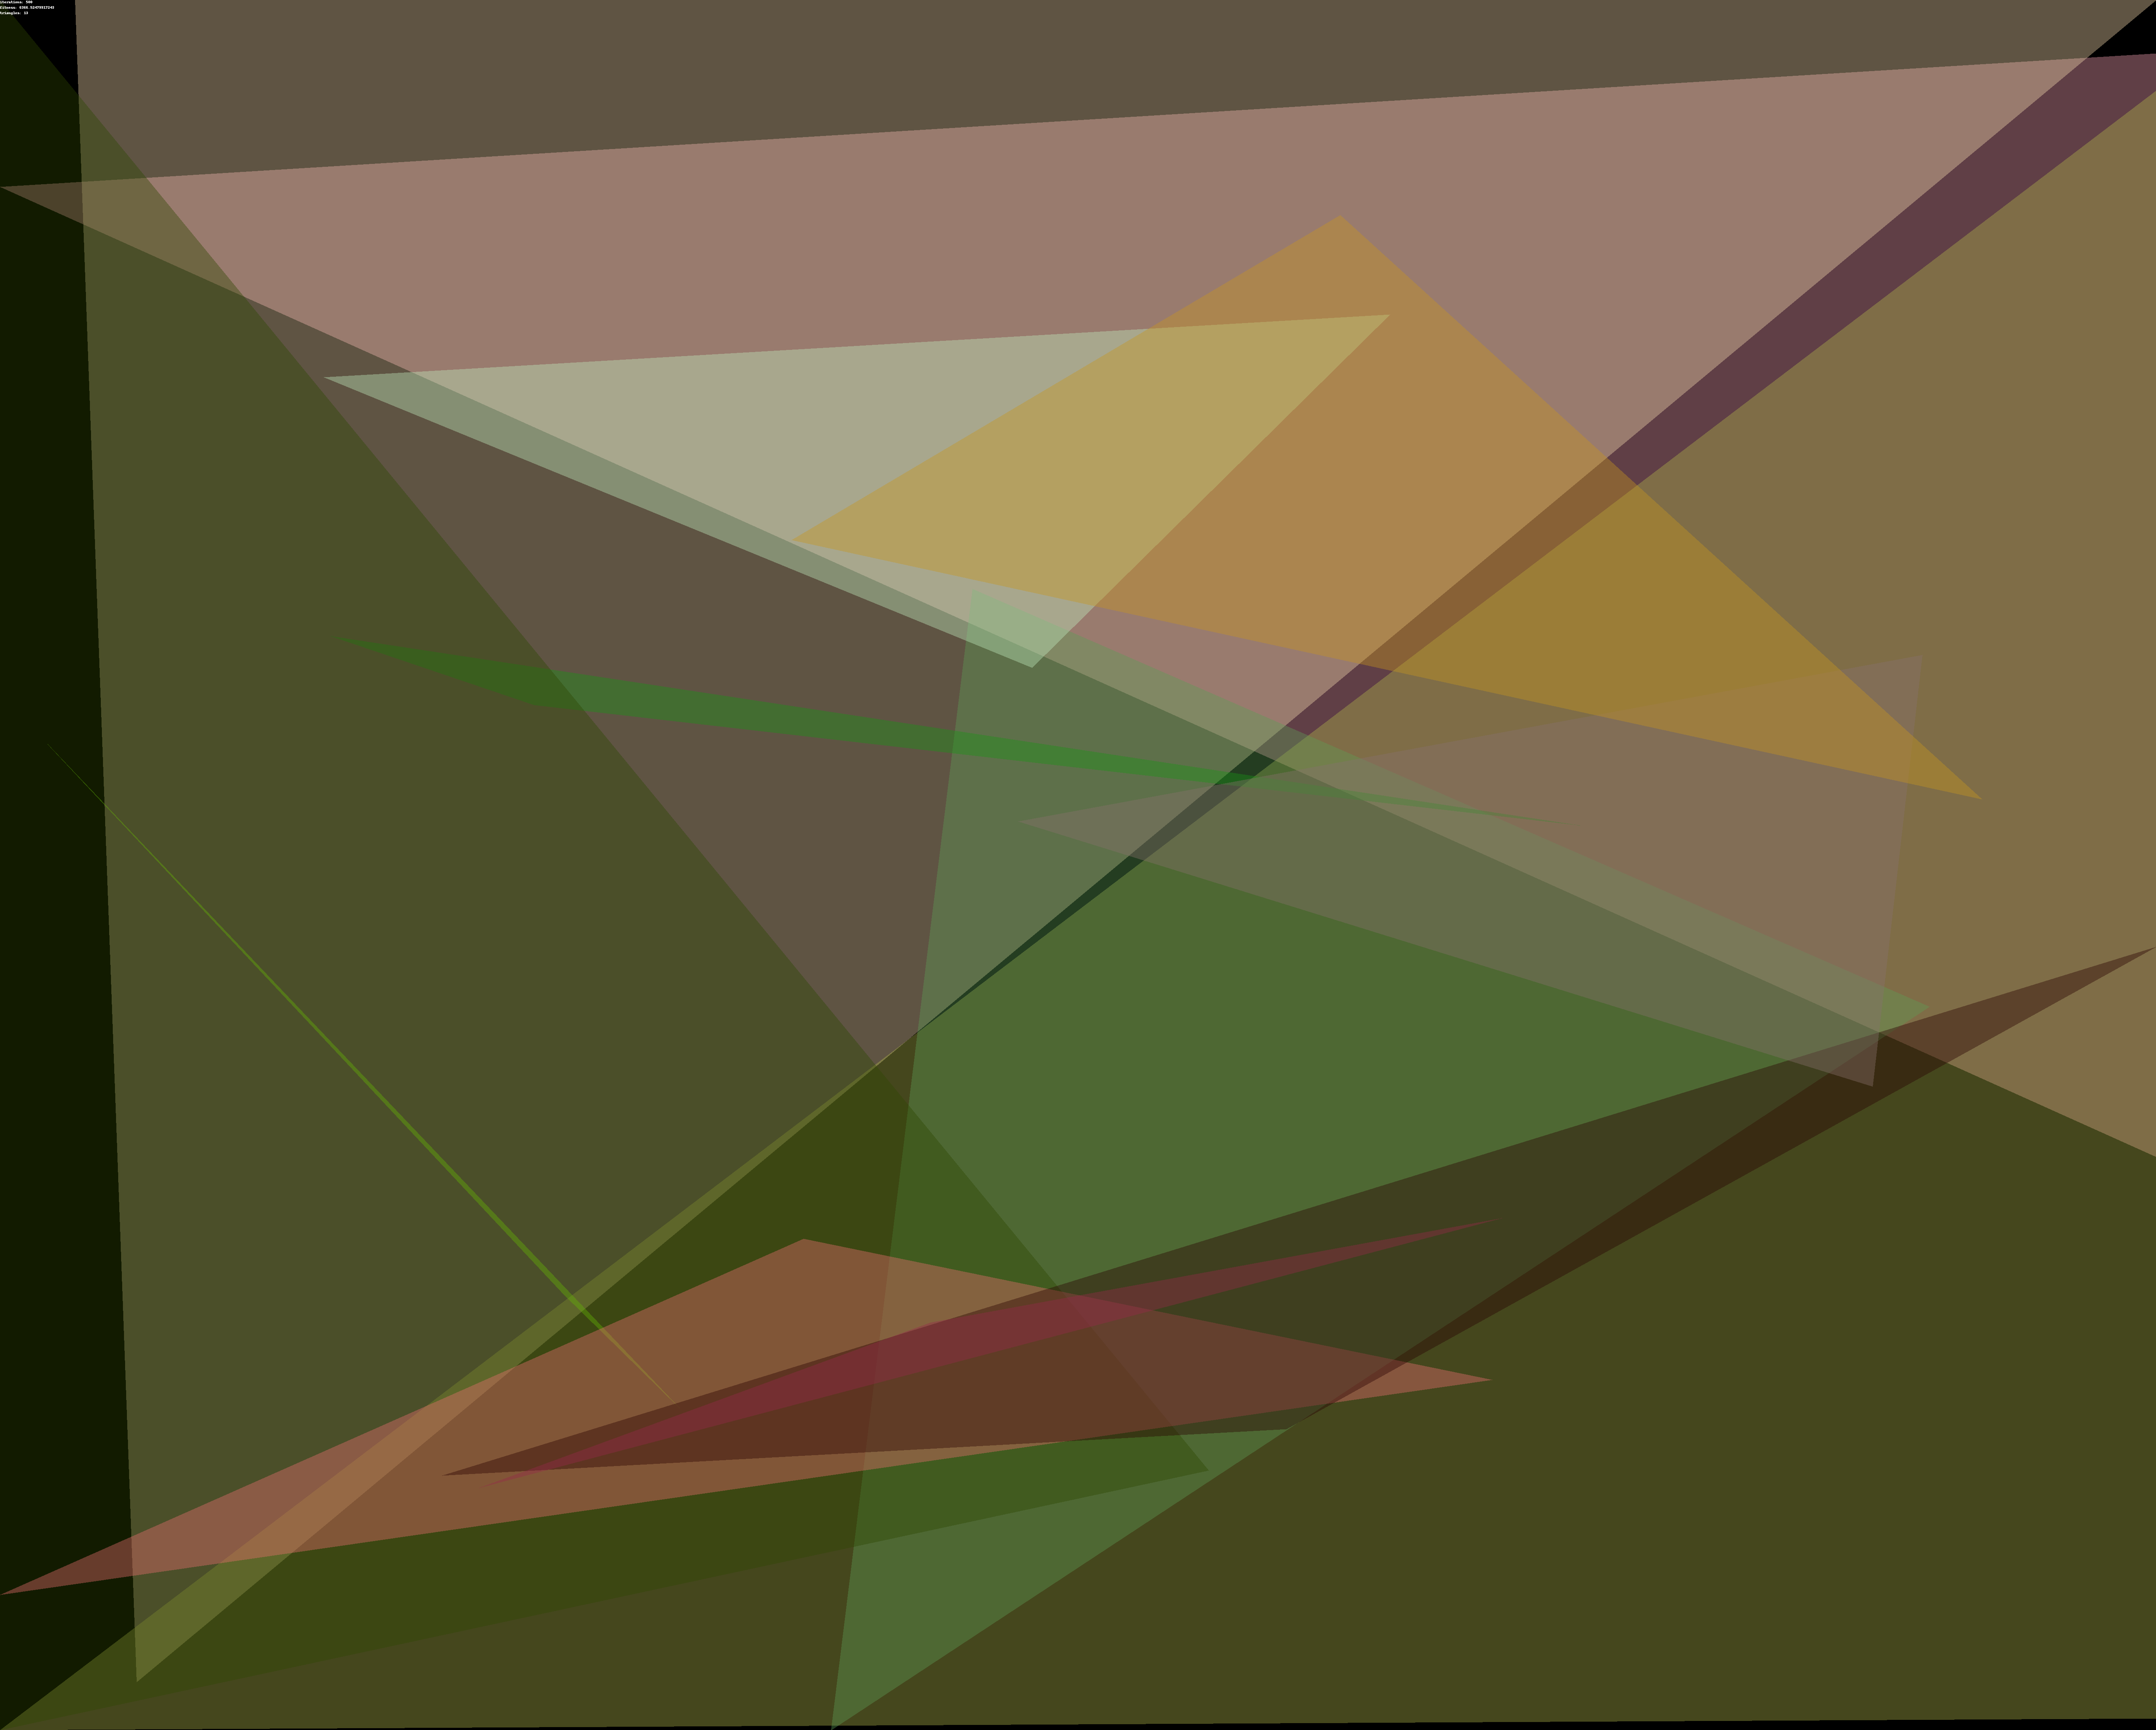

t: 600 fitness: 6483.331594988587 triangles: 15


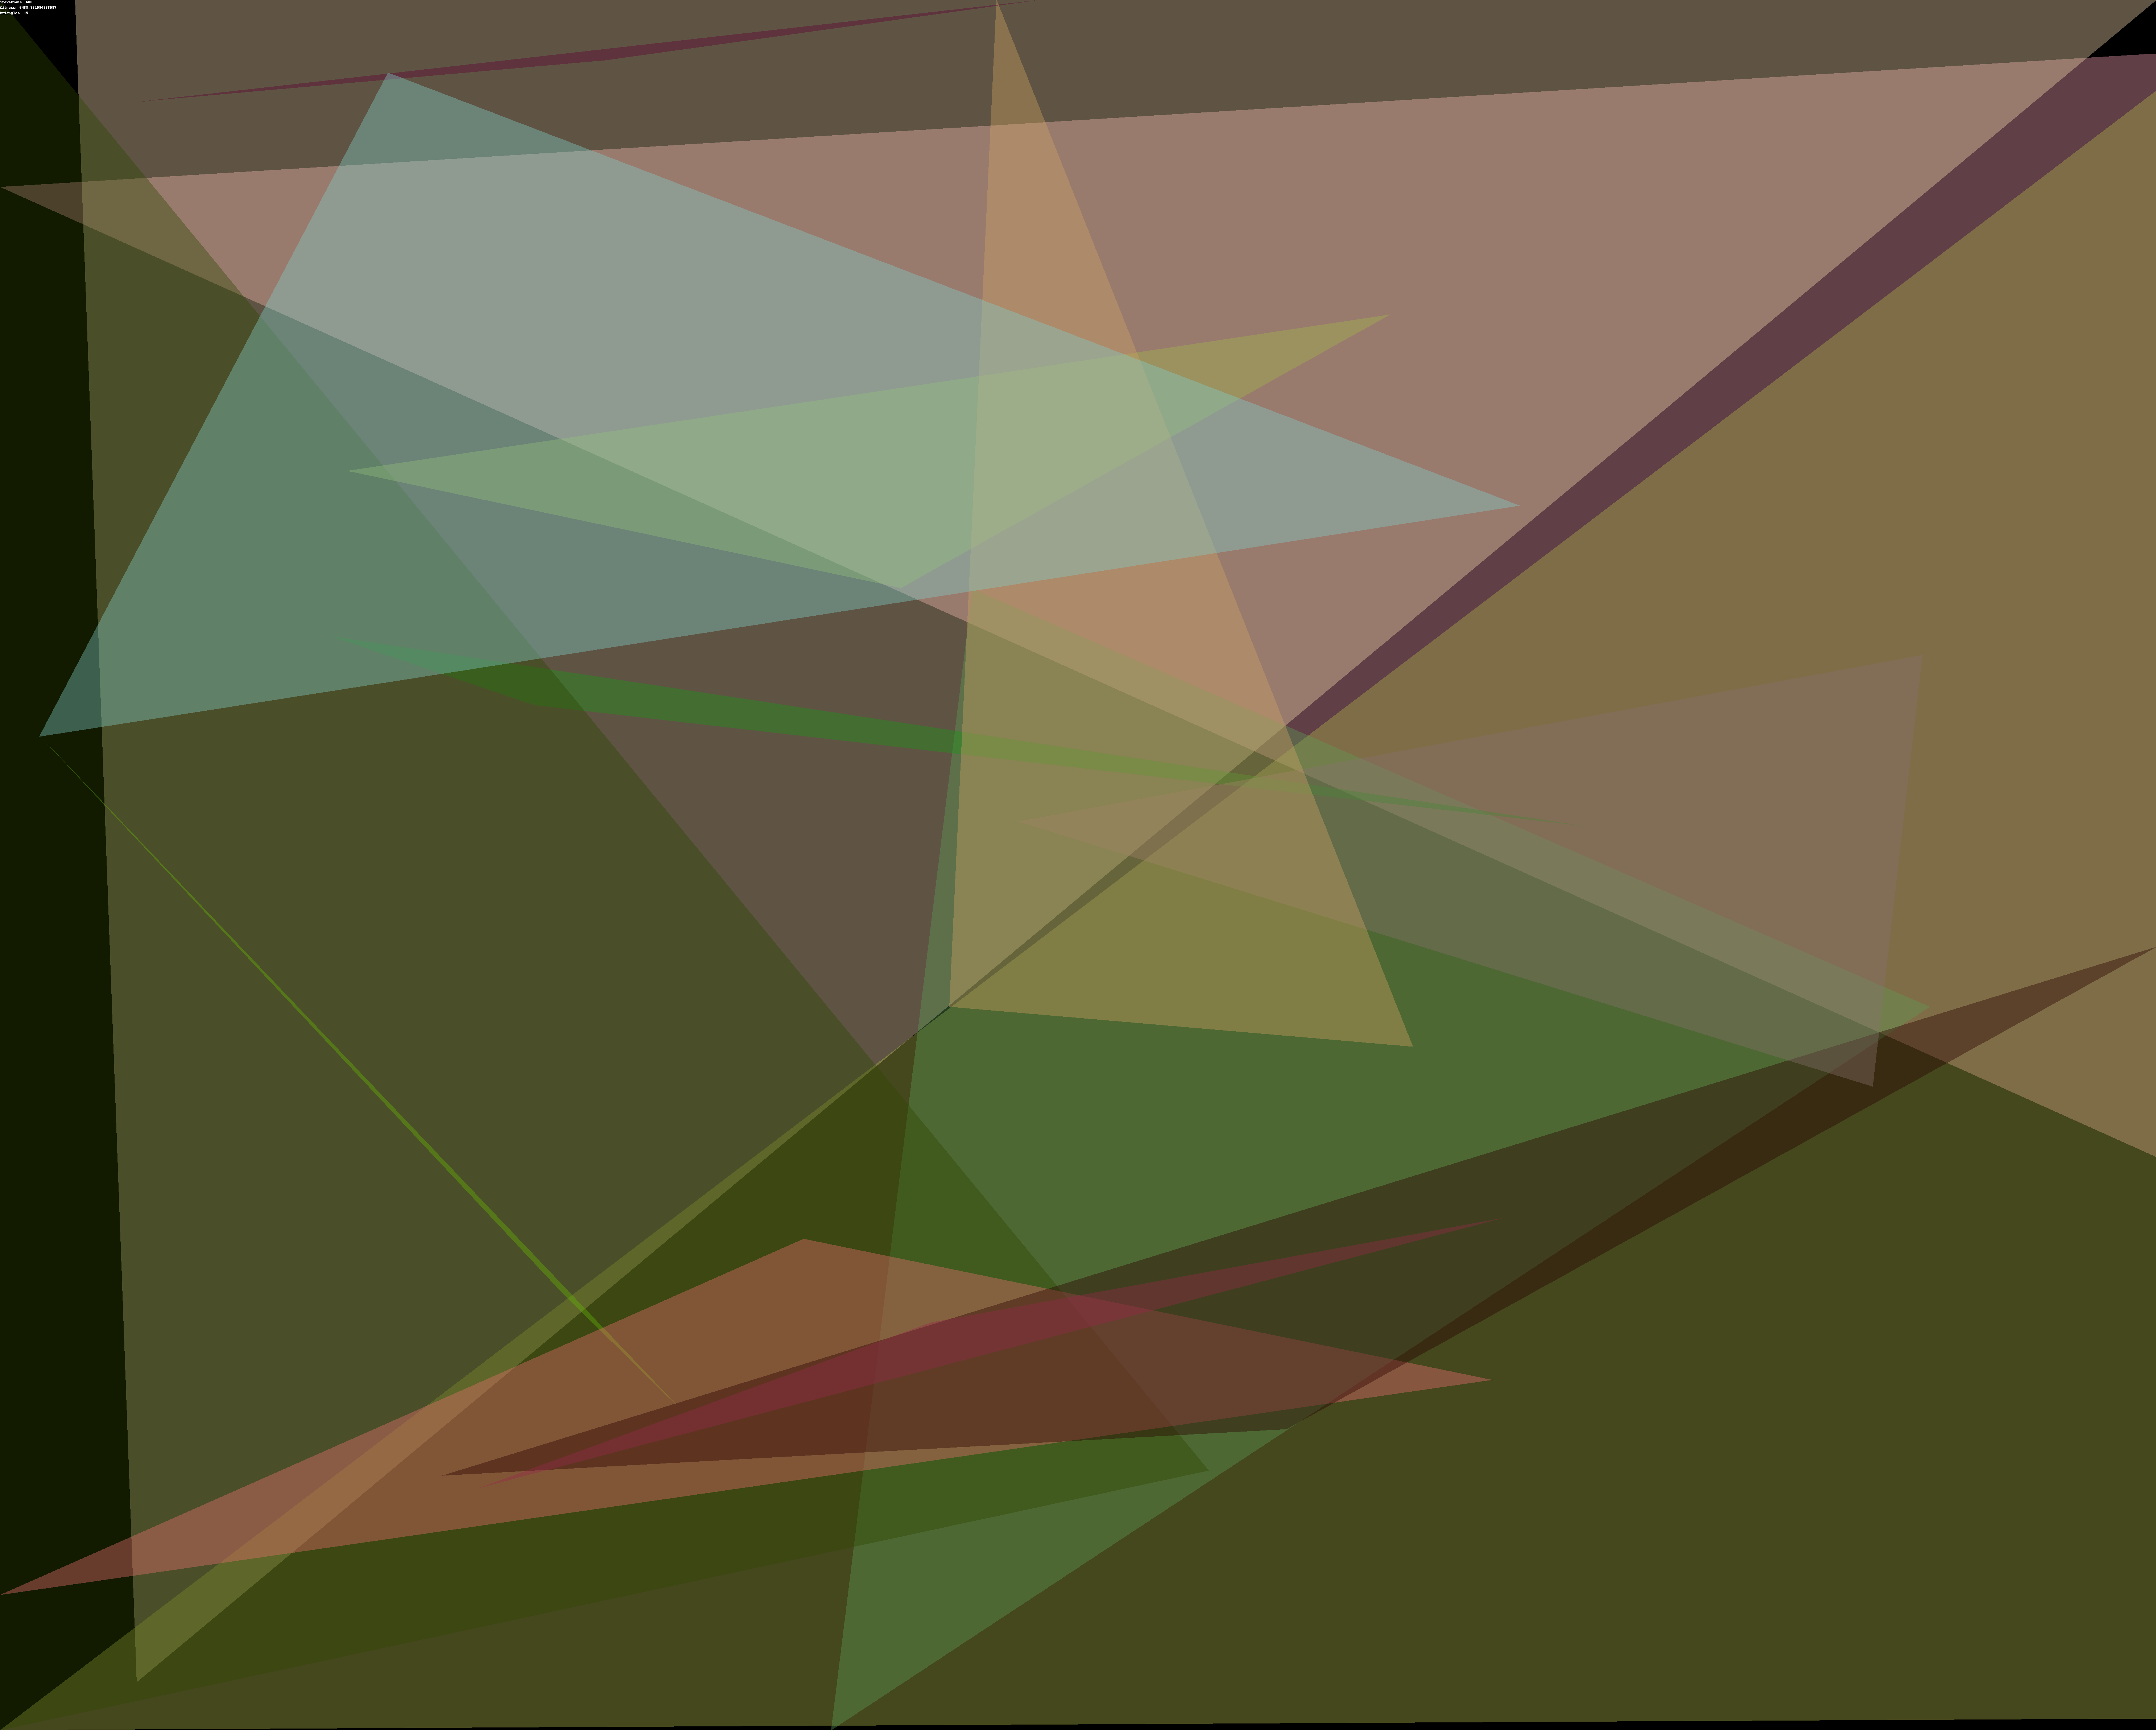

t: 700 fitness: 6391.426883346048 triangles: 17


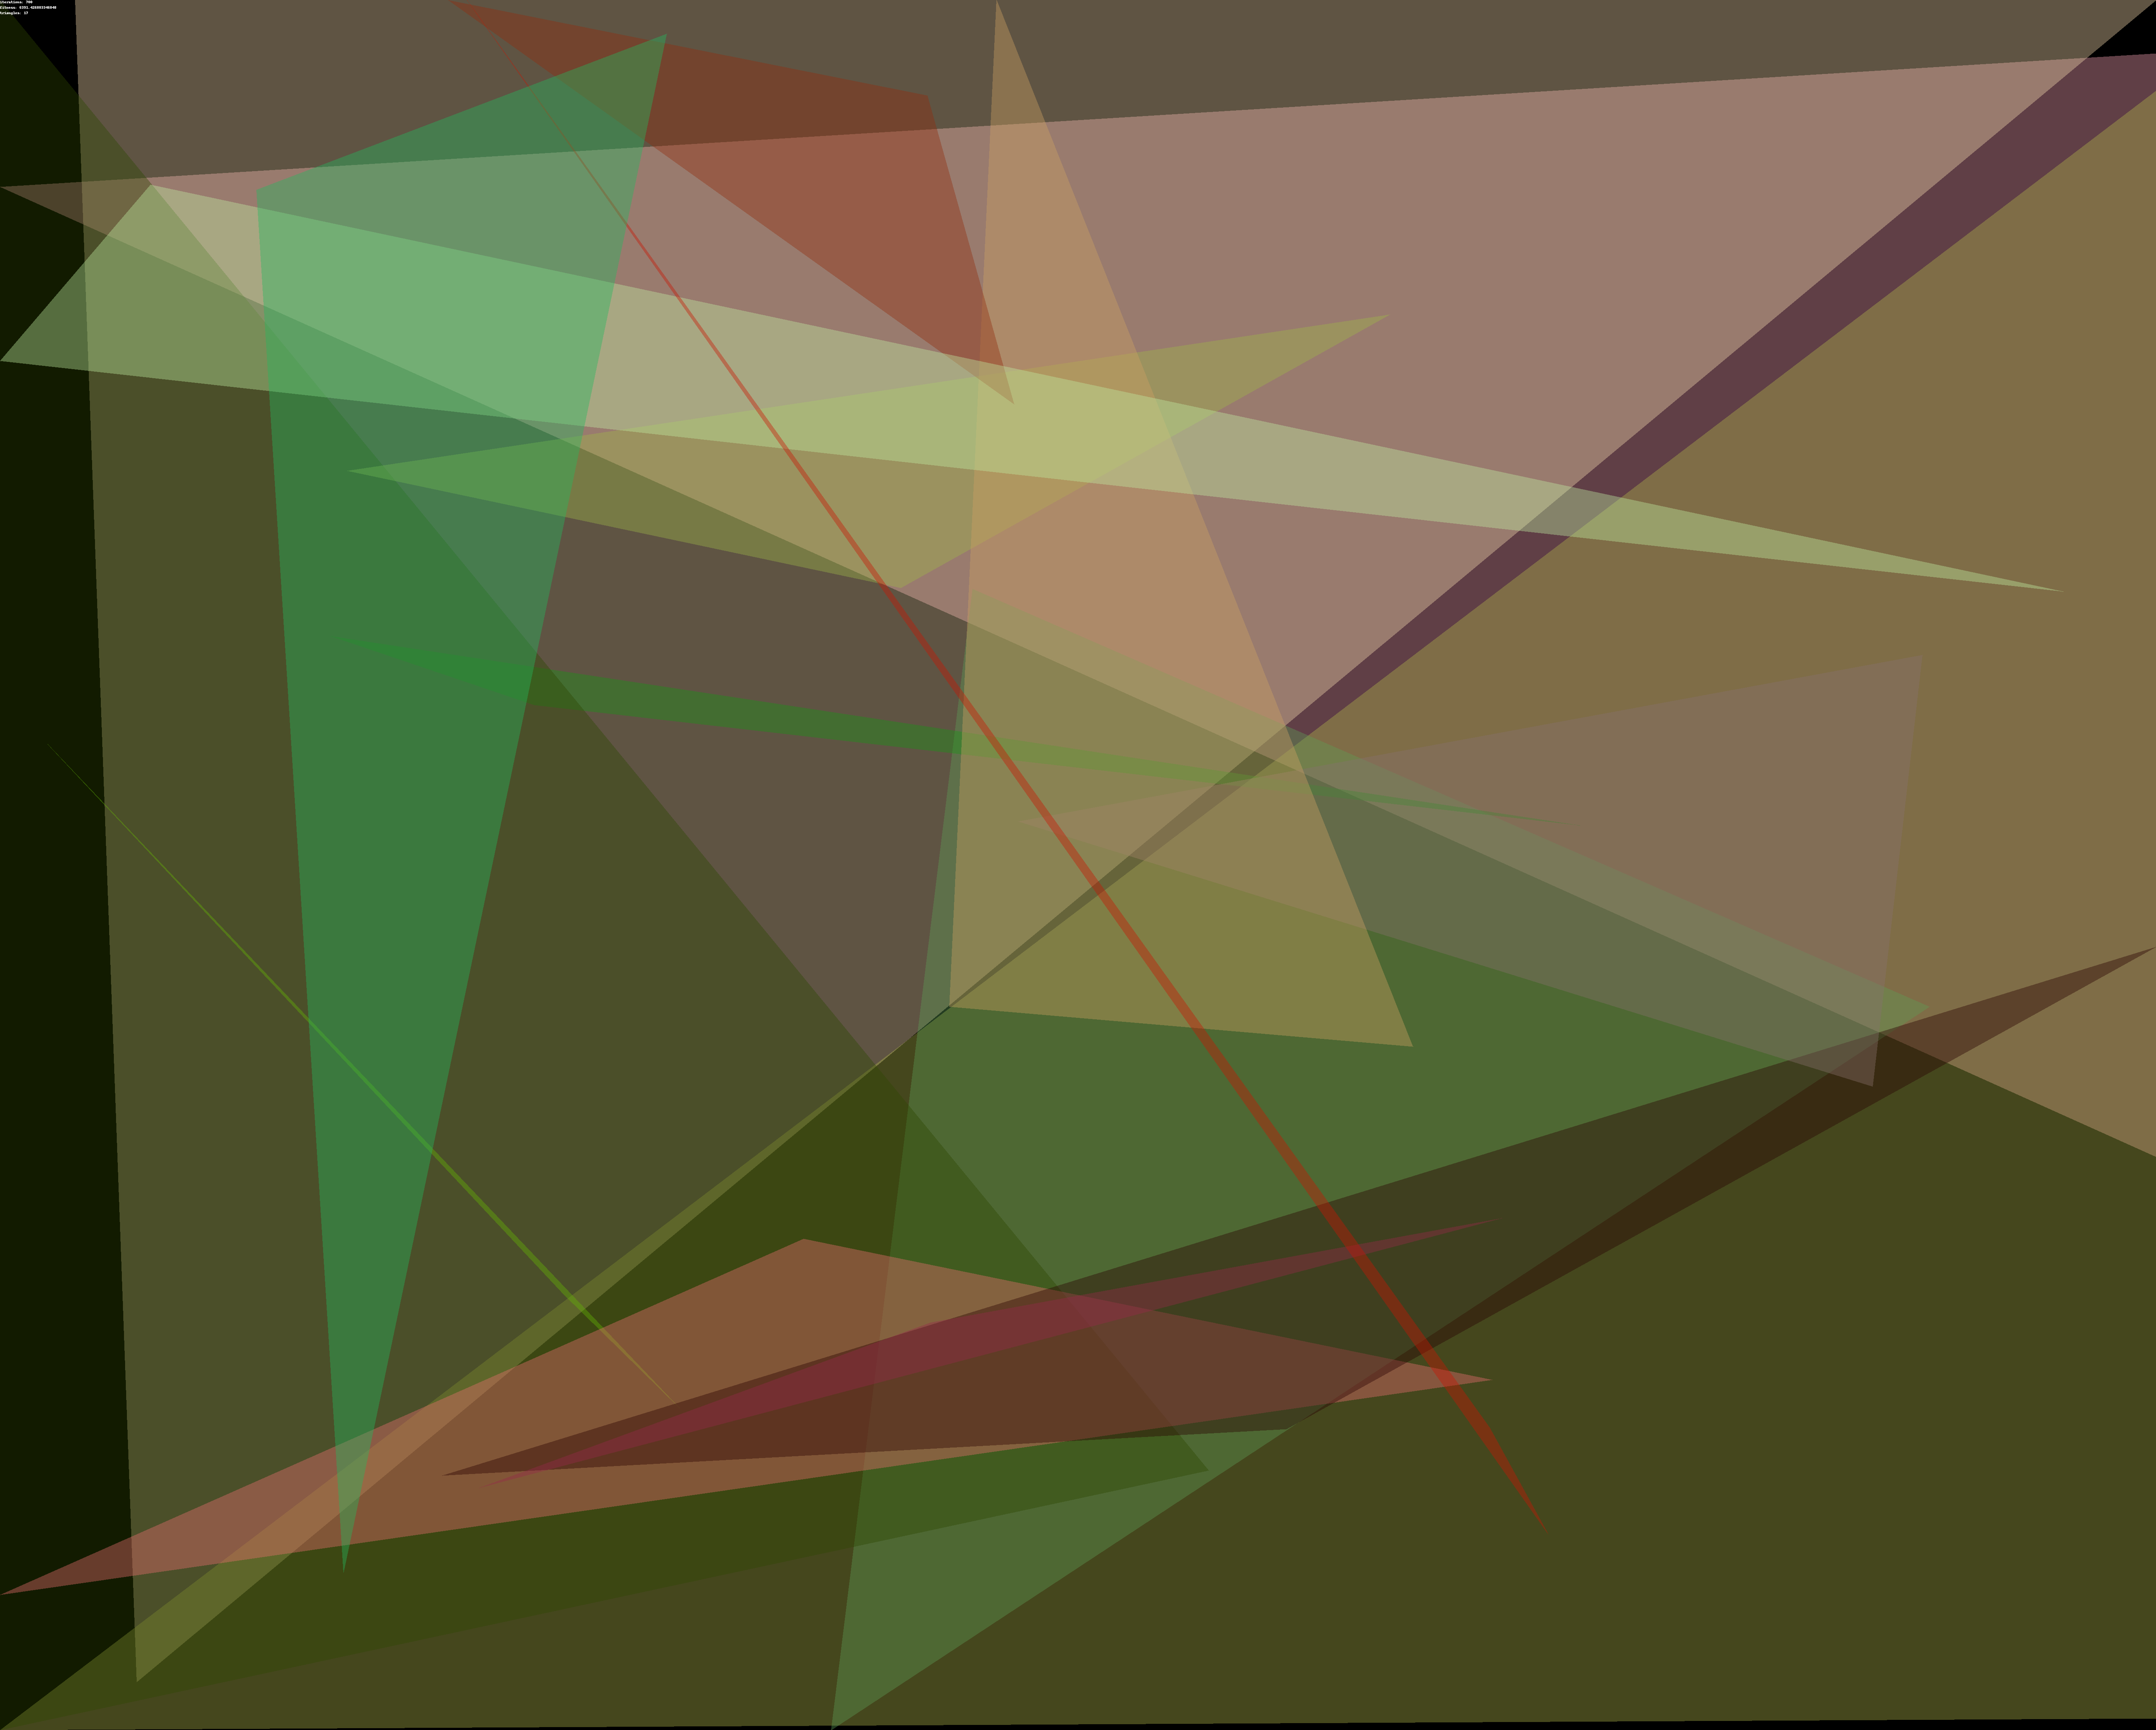

t: 800 fitness: 6024.25614002583 triangles: 19


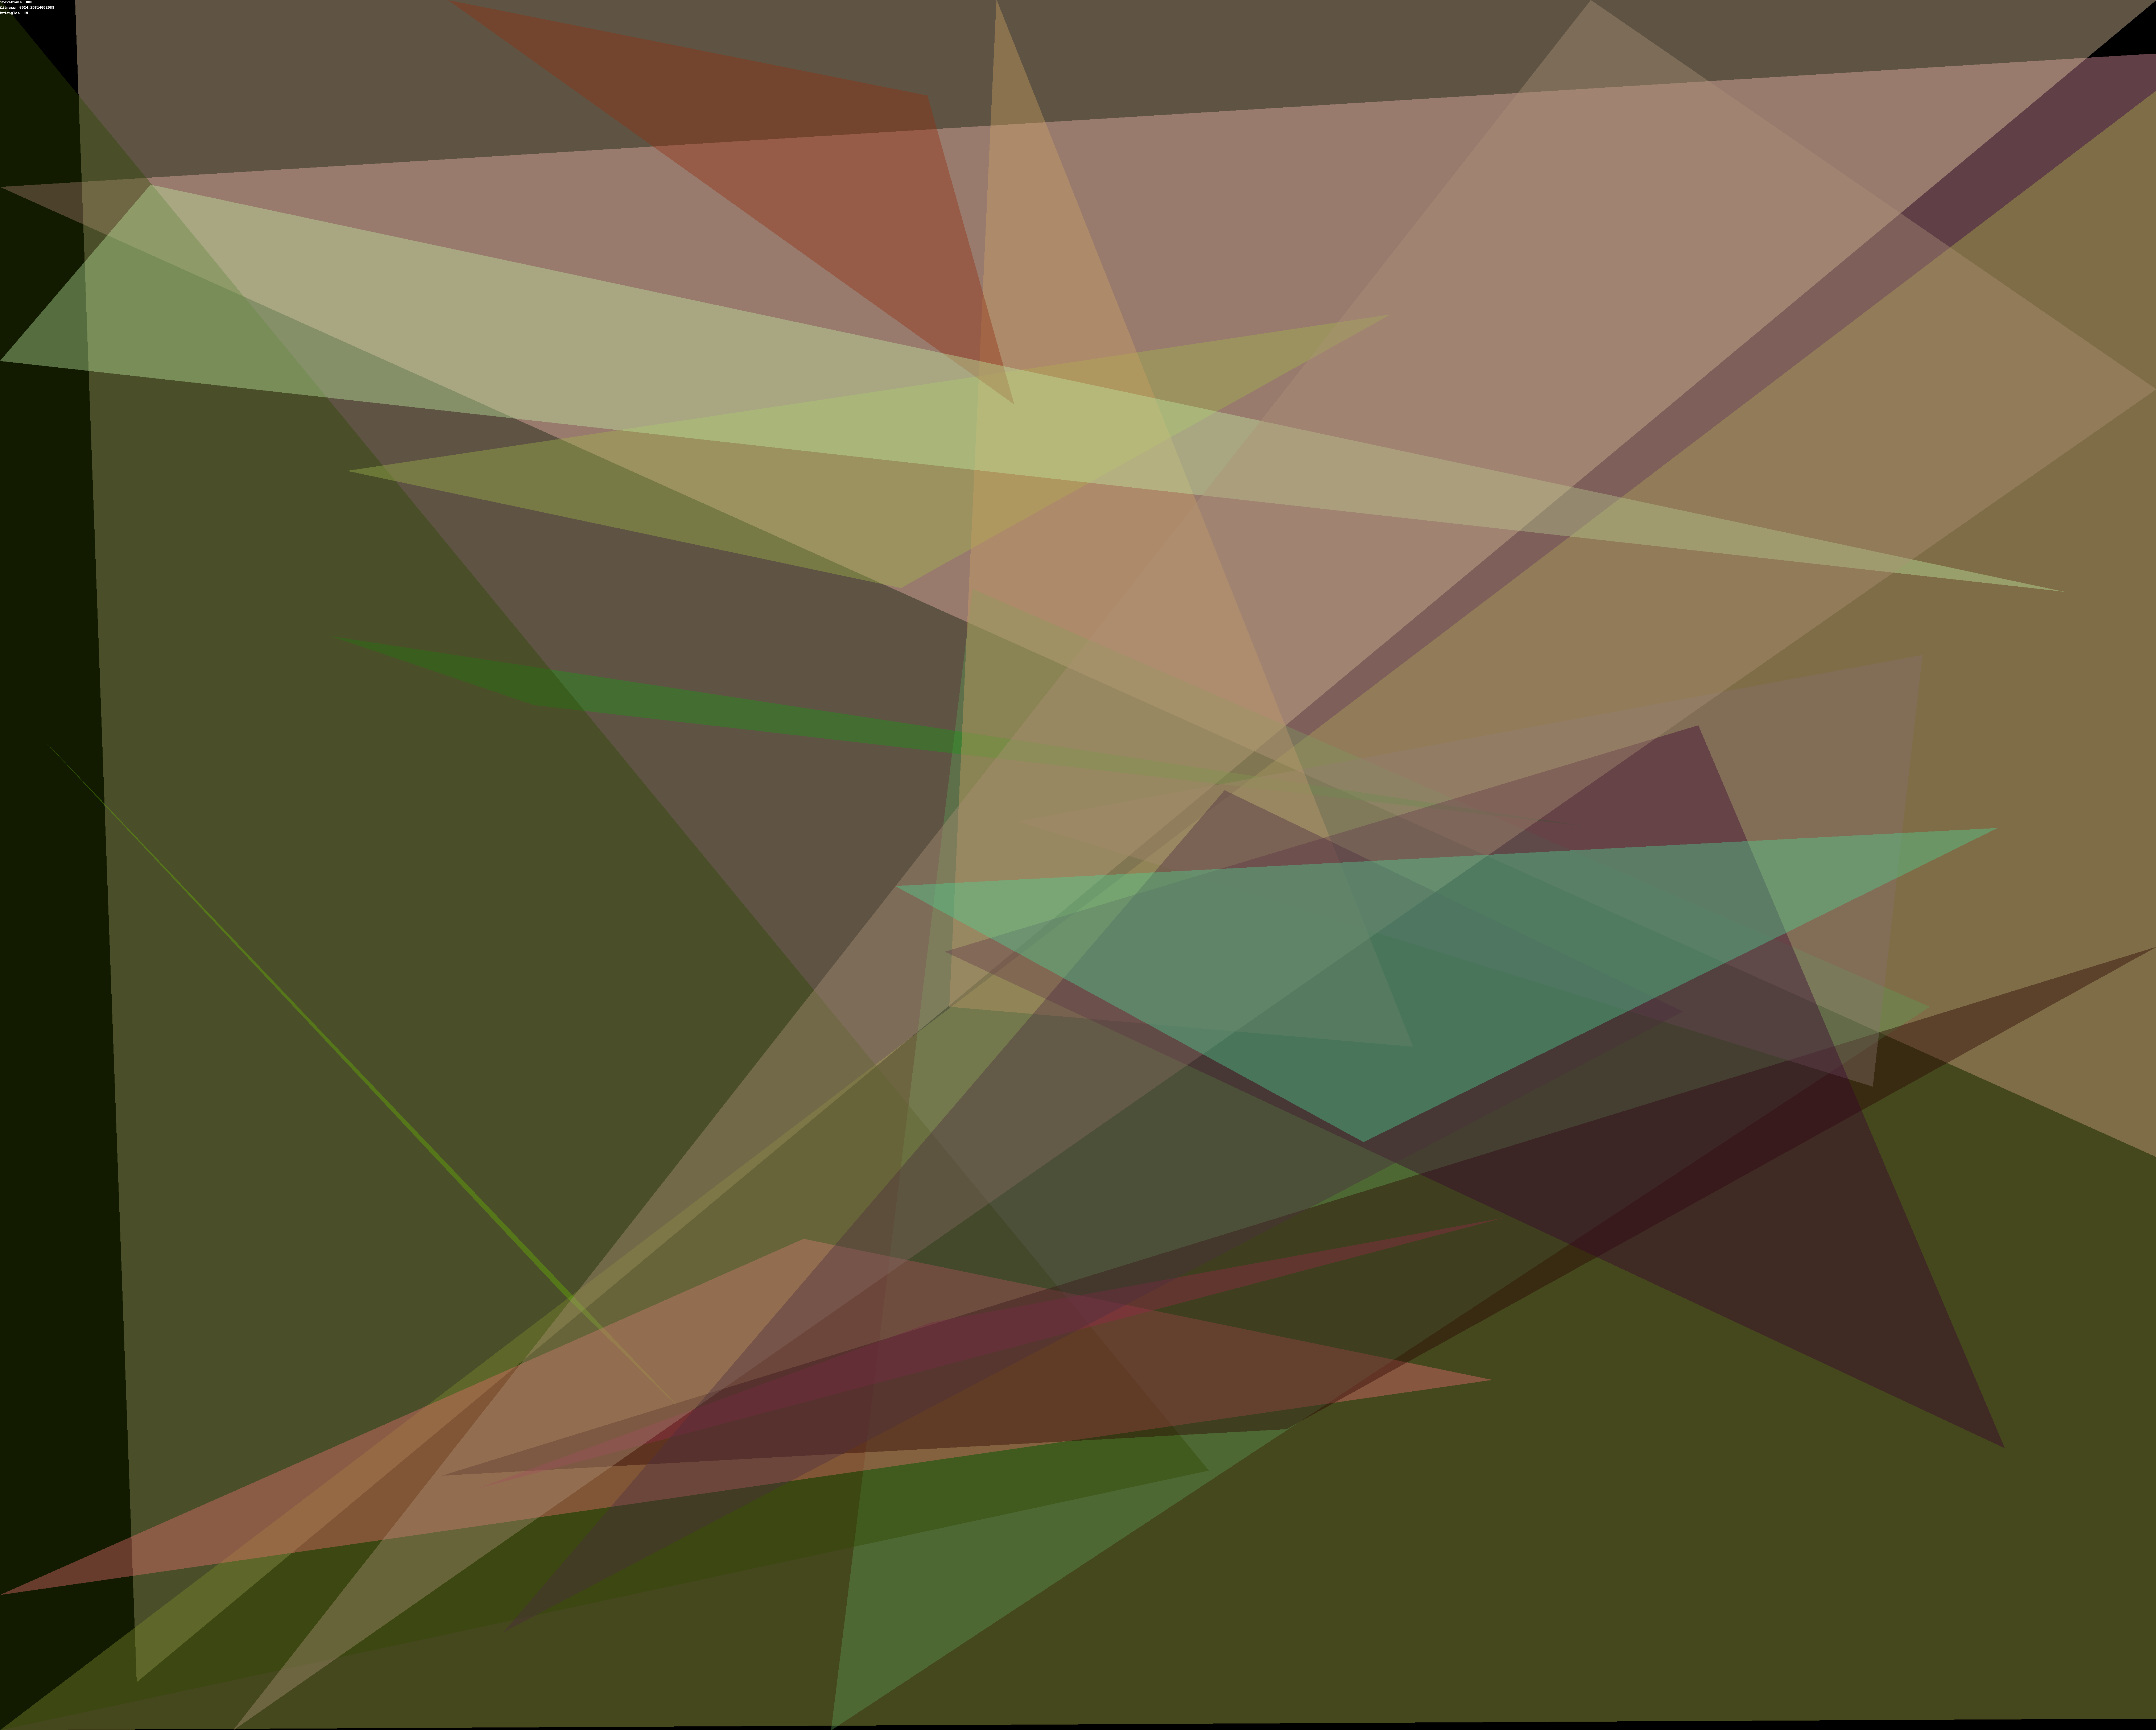

t: 900 fitness: 5944.557261810567 triangles: 21


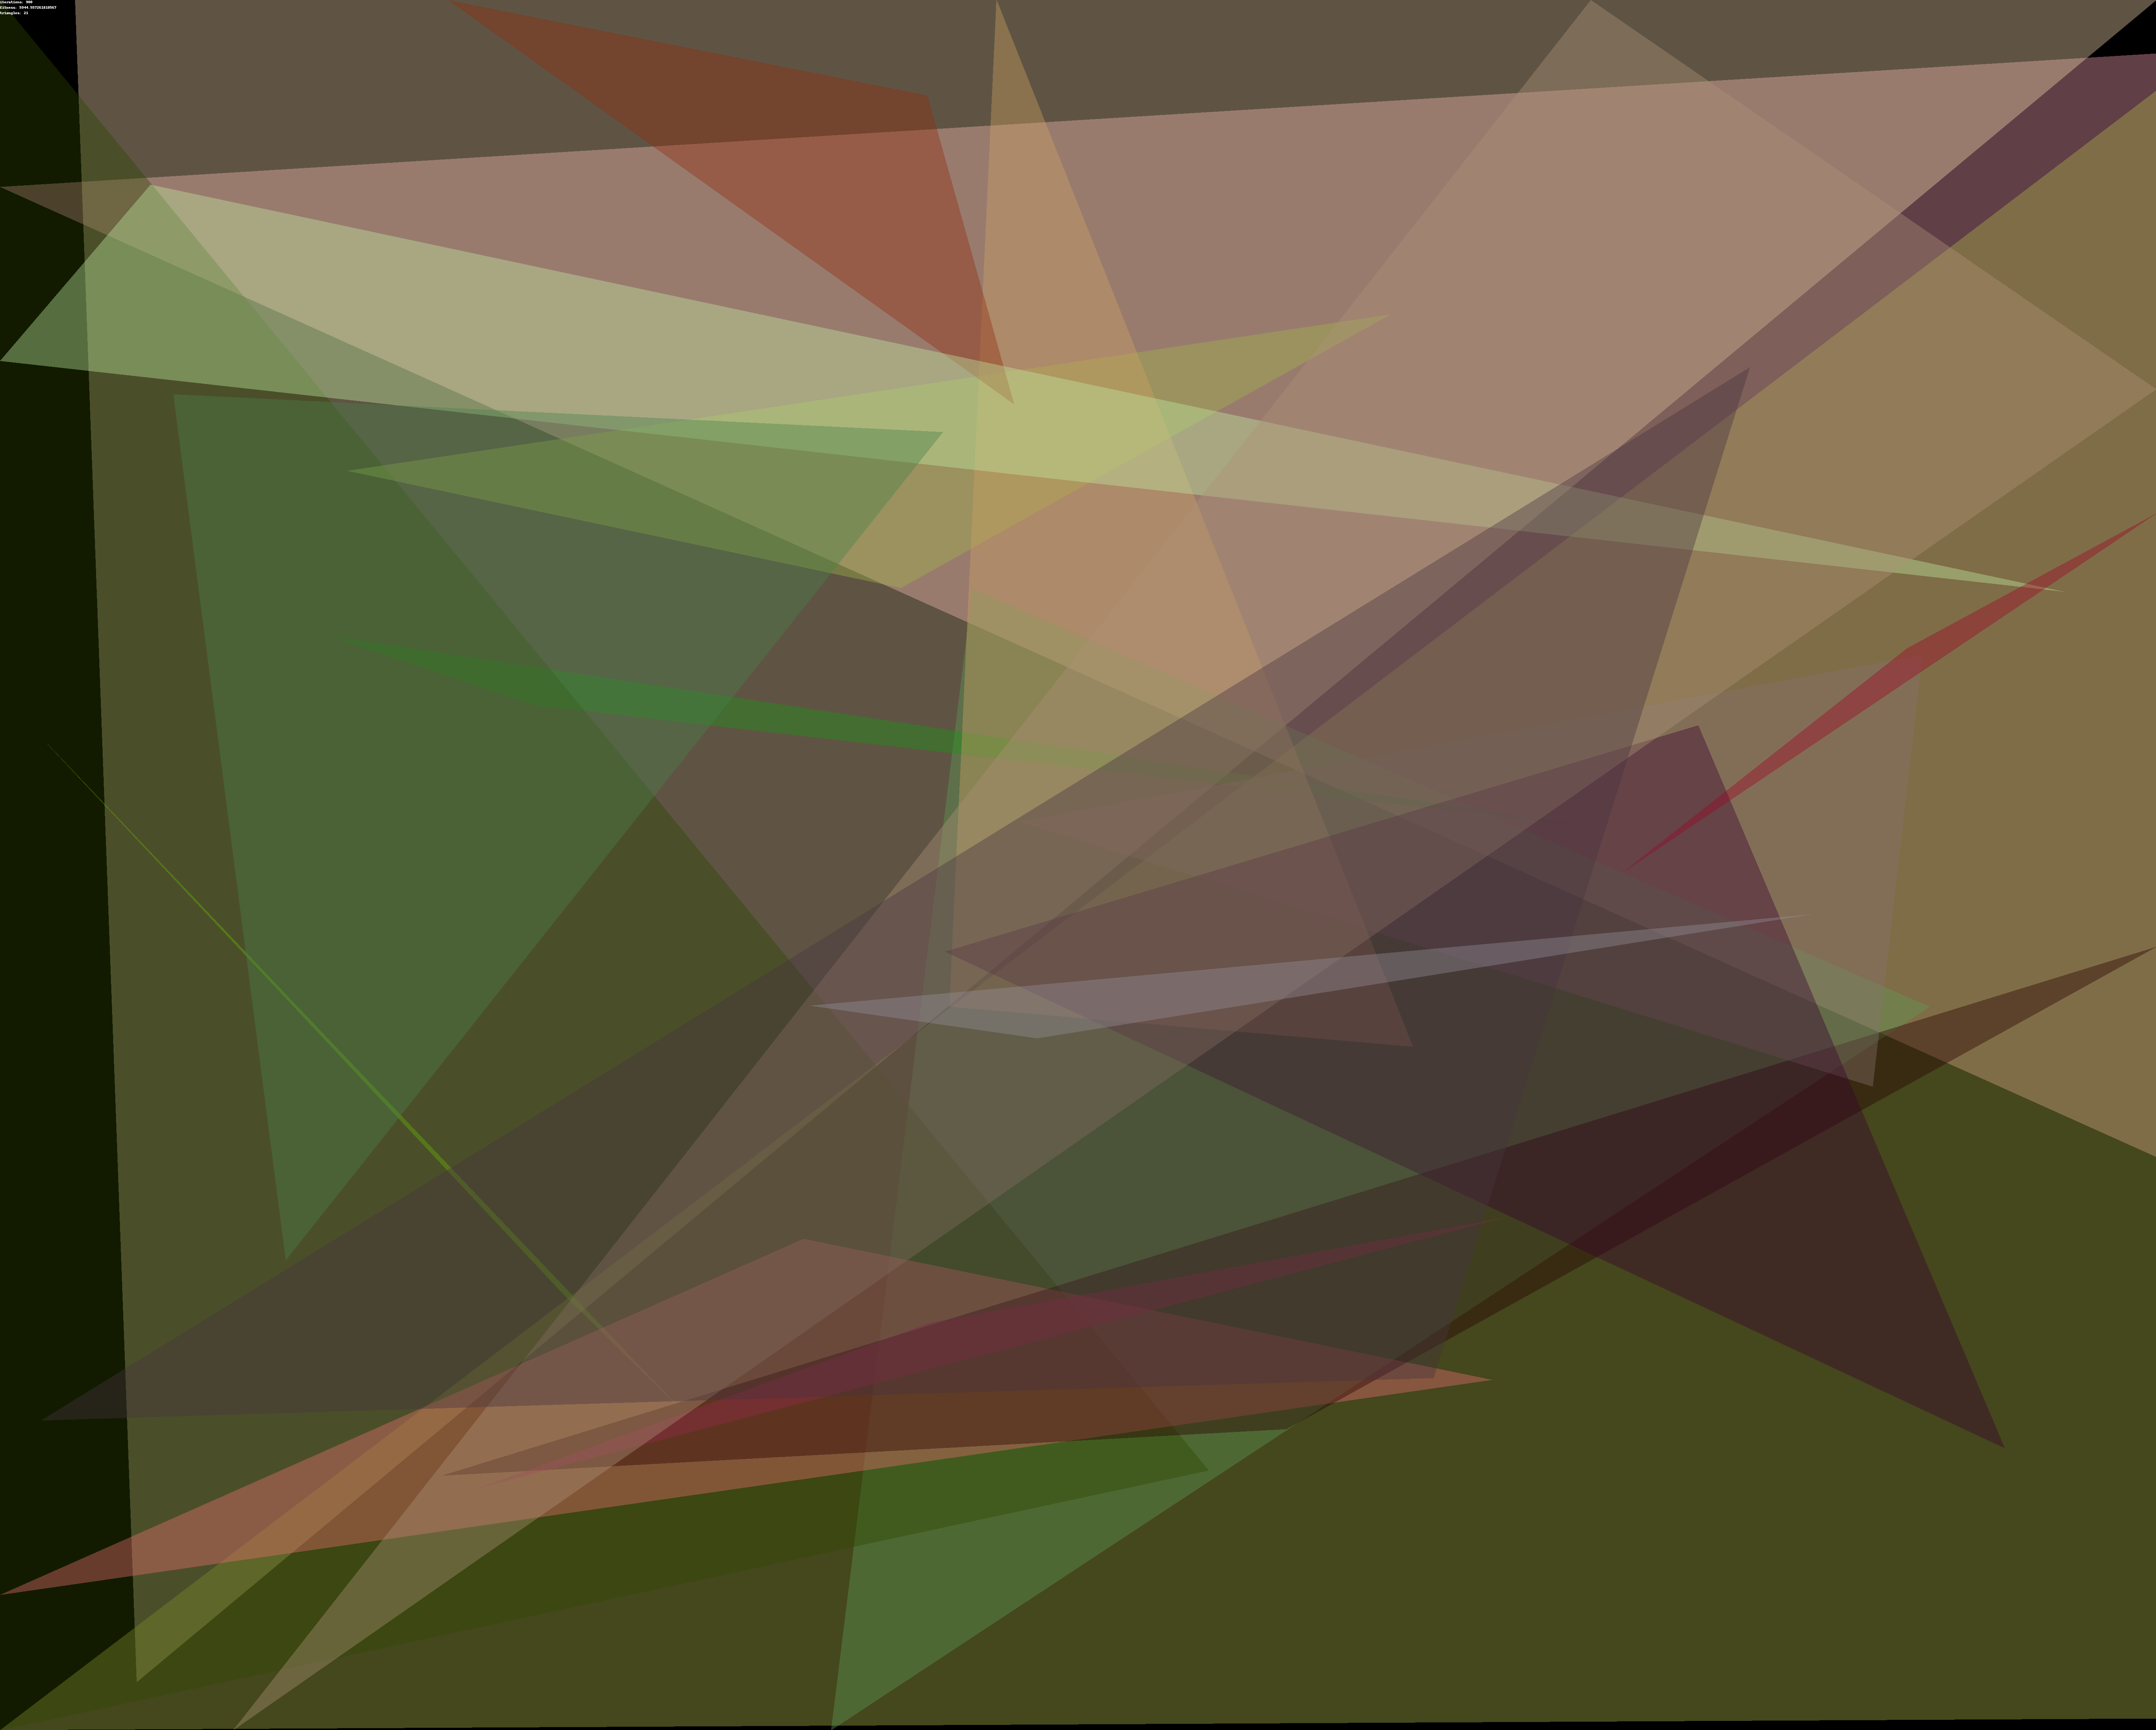

t: 1000 fitness: 5817.688771429415 triangles: 23


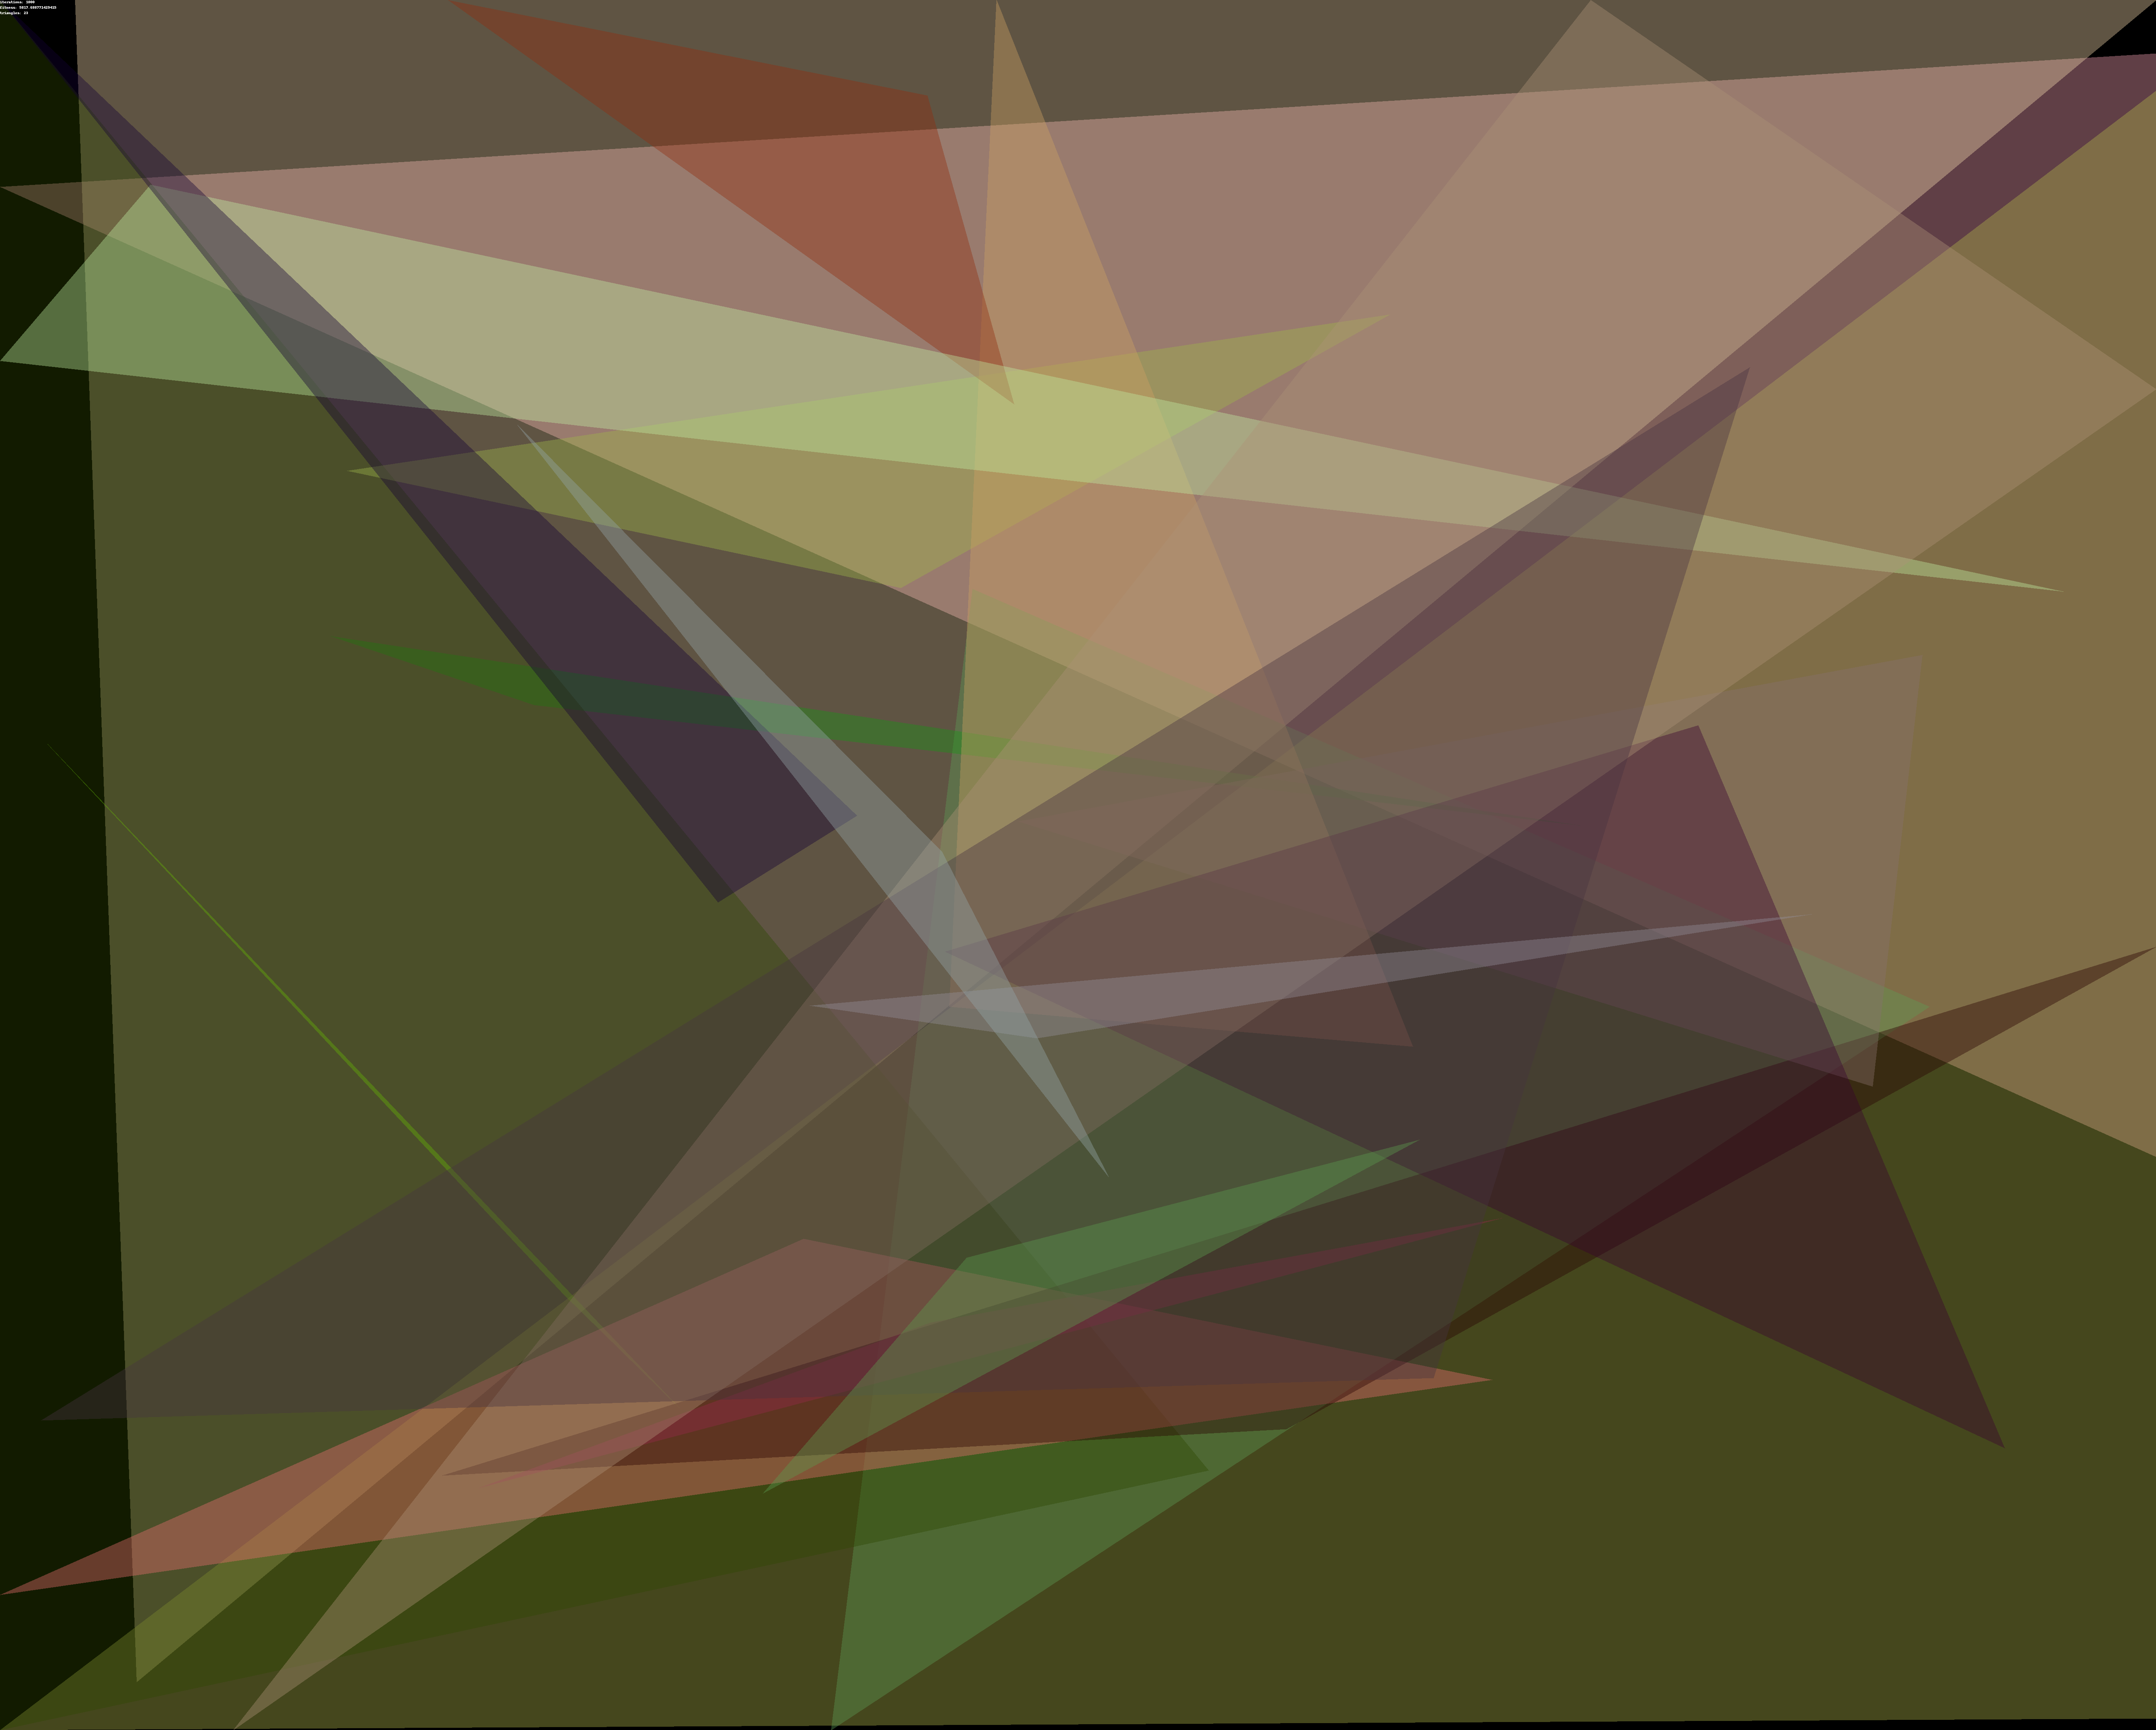

t: 1100 fitness: 5829.094930388306 triangles: 25


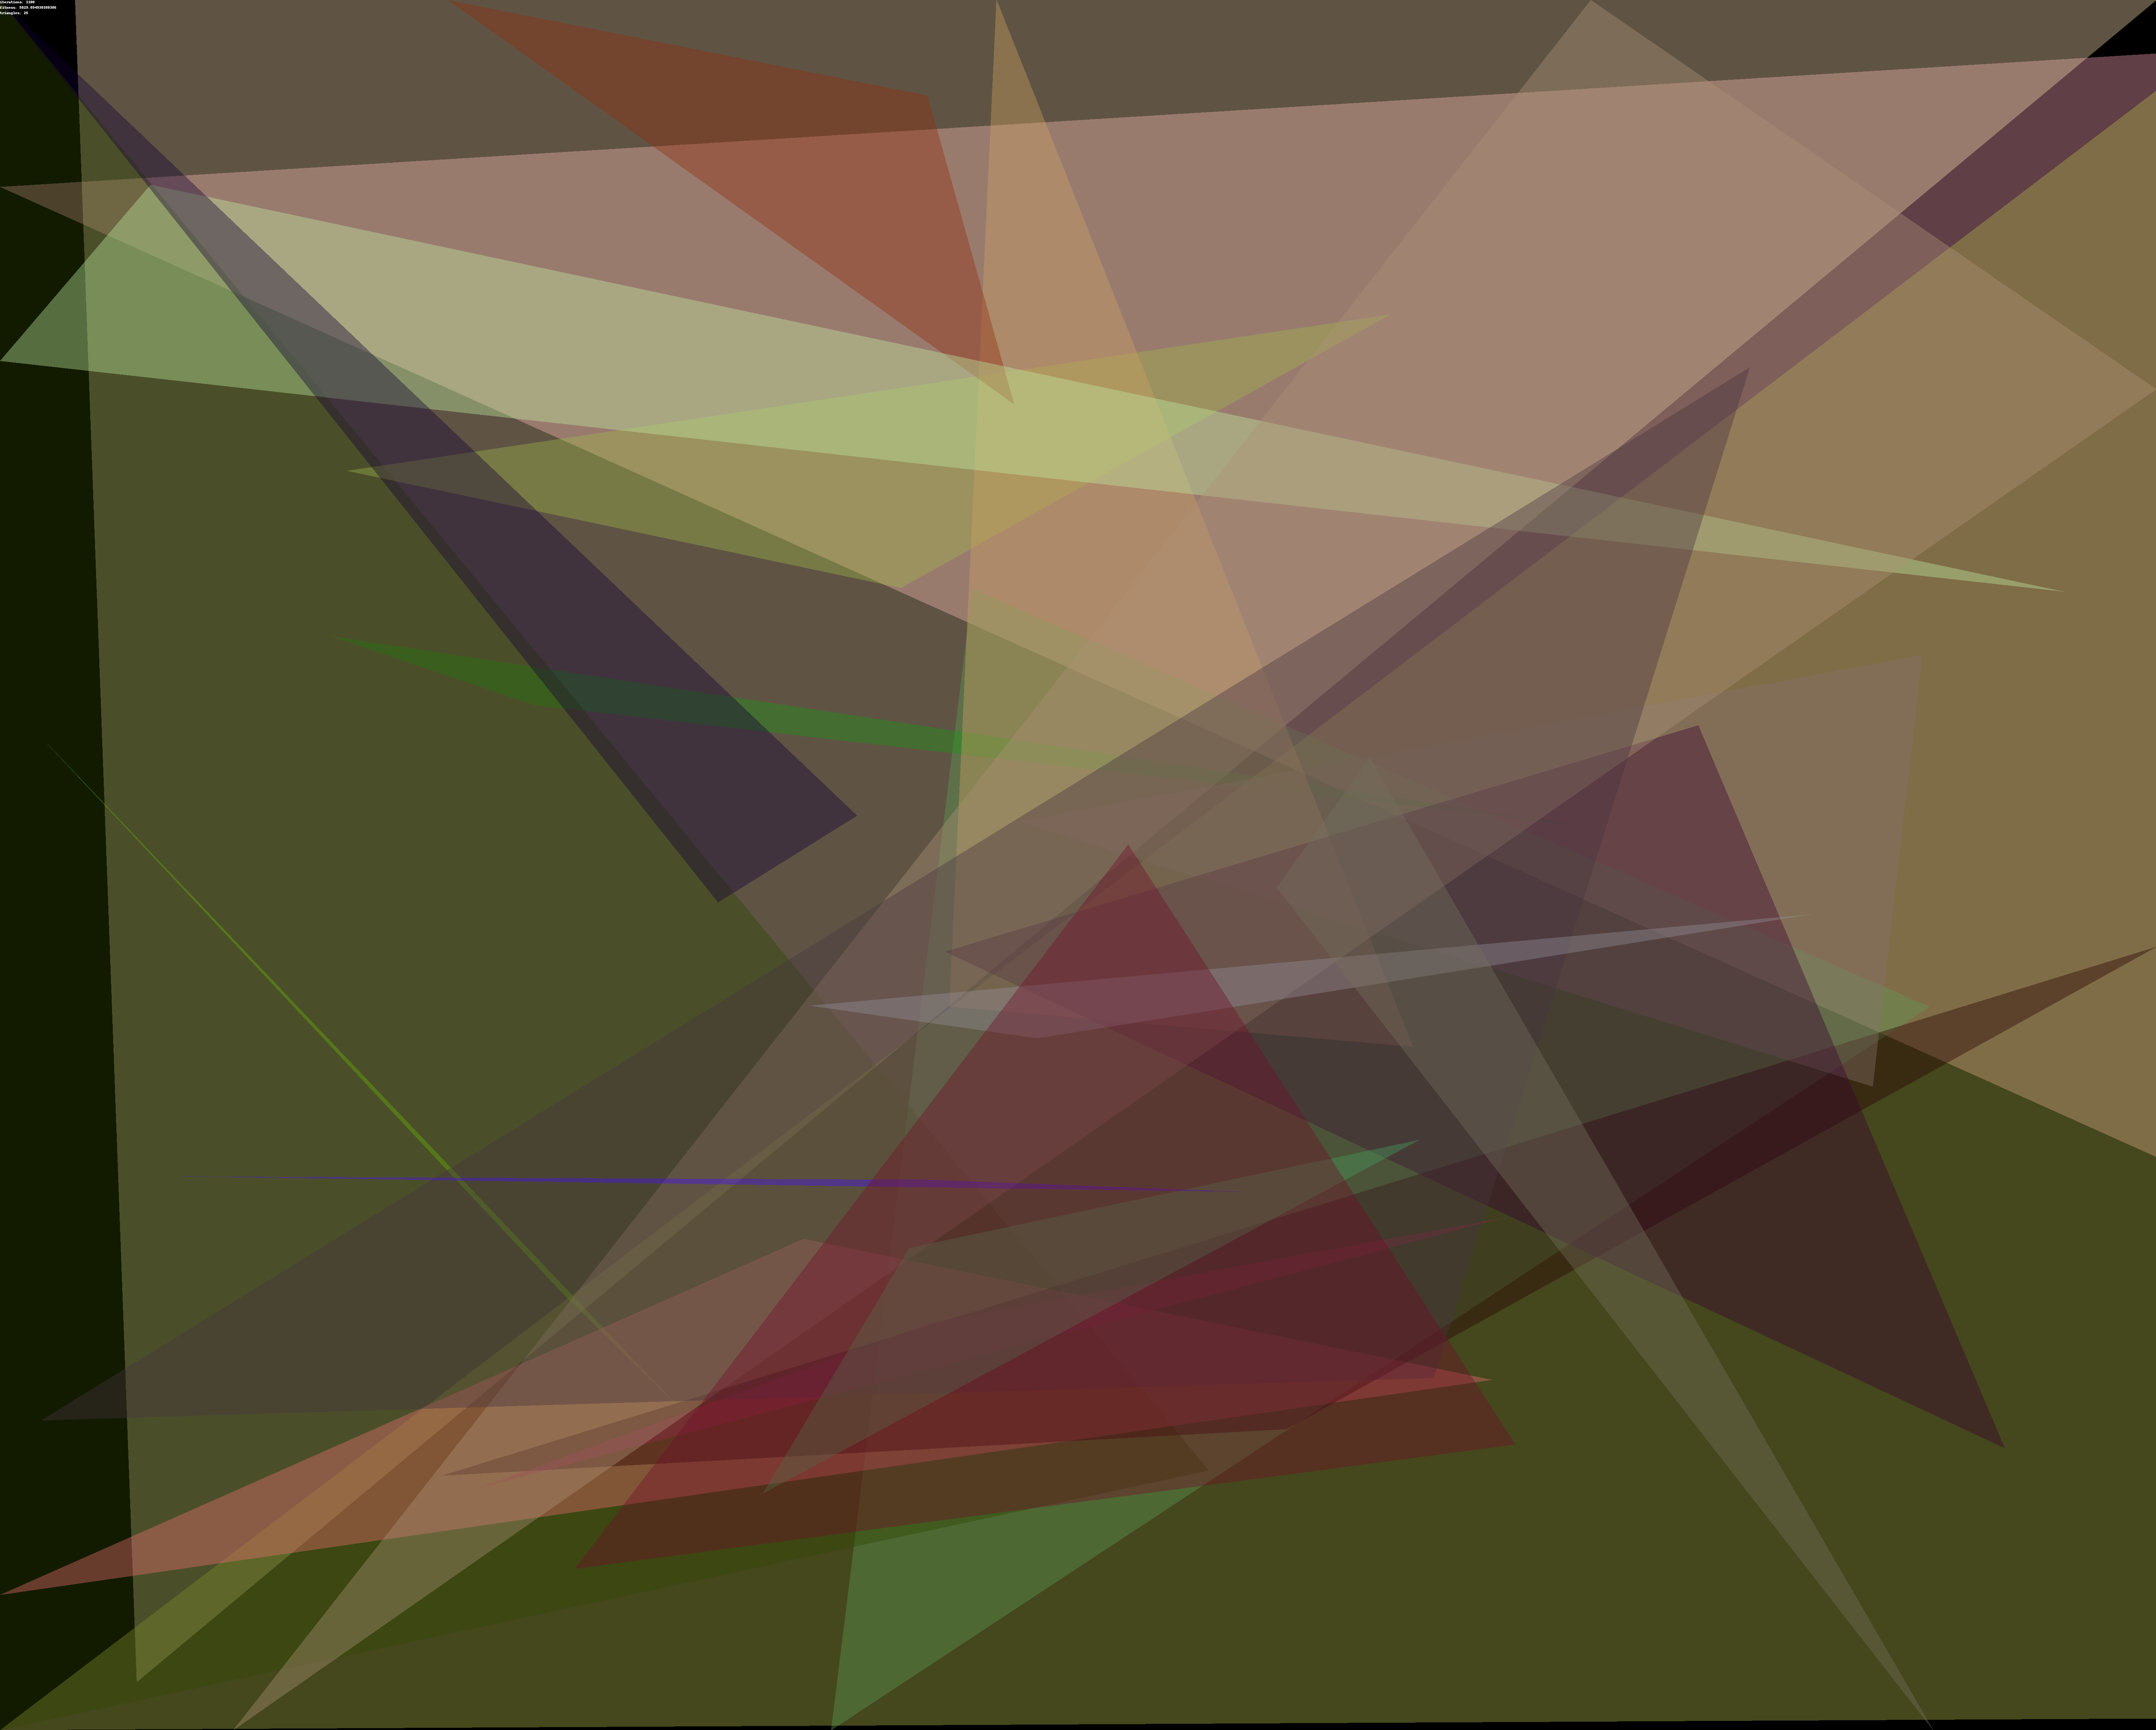

t: 1200 fitness: 6071.7975200616065 triangles: 27


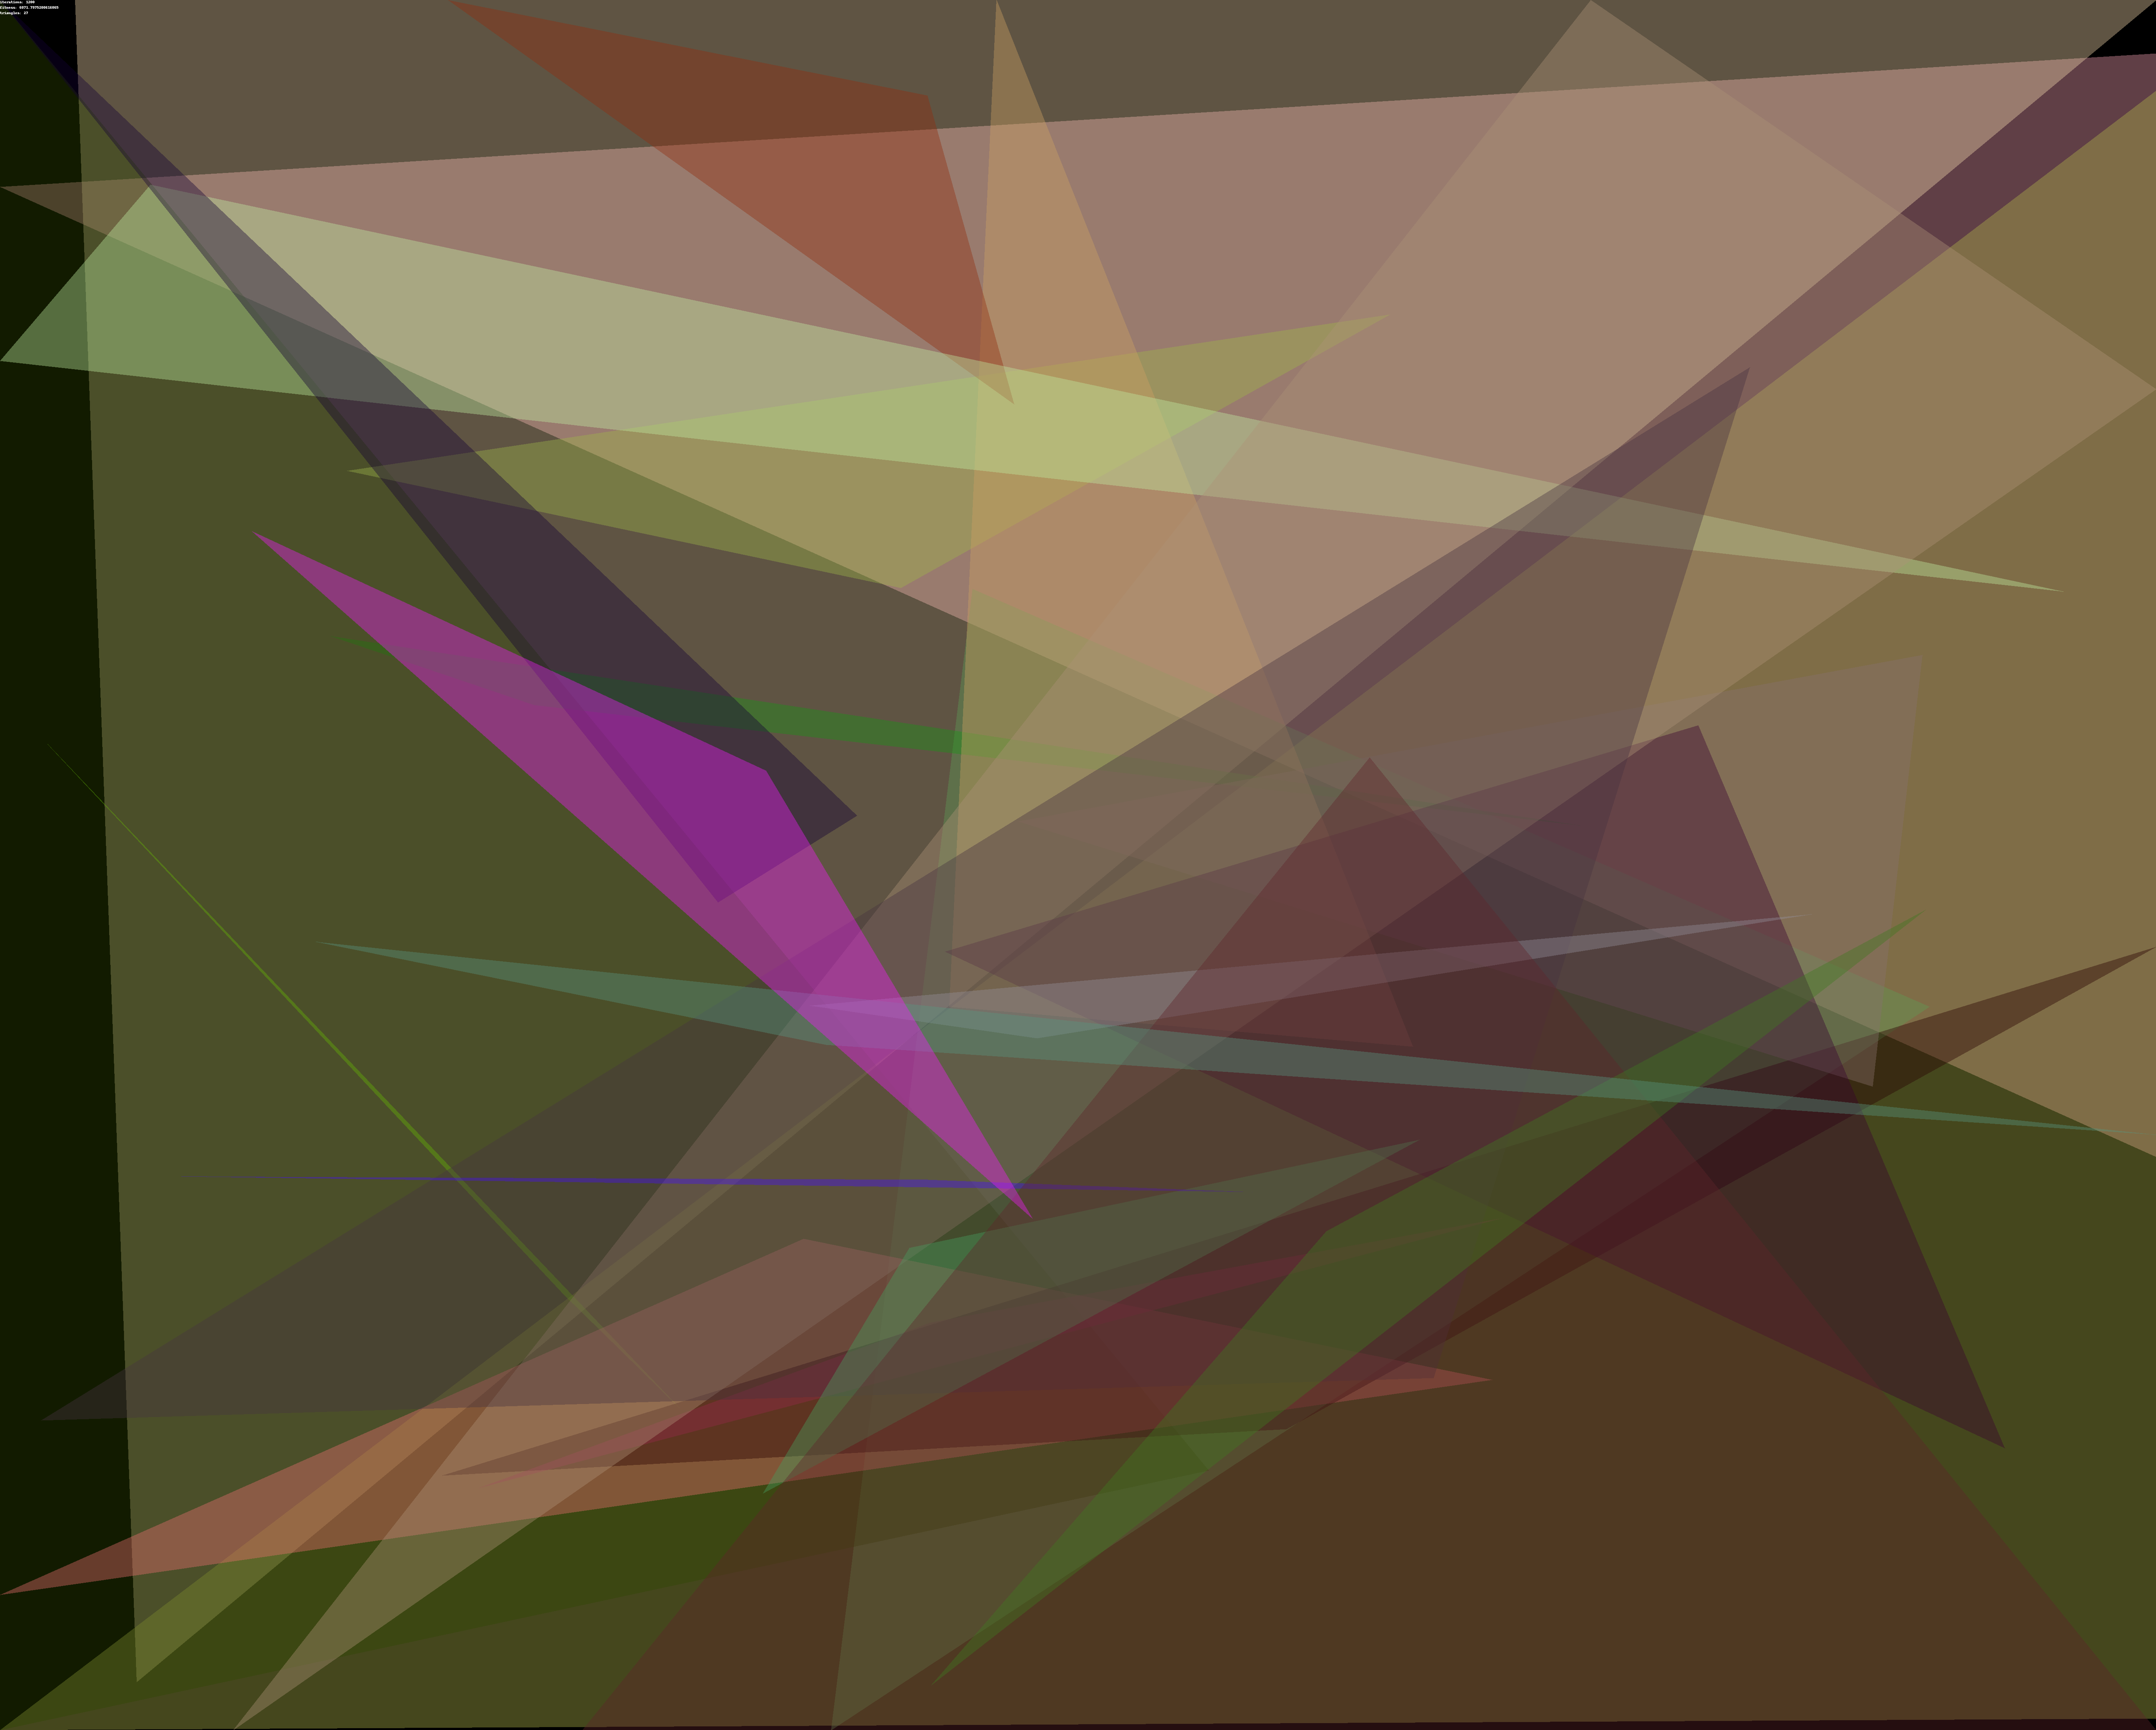

t: 1300 fitness: 6223.500241289893 triangles: 29


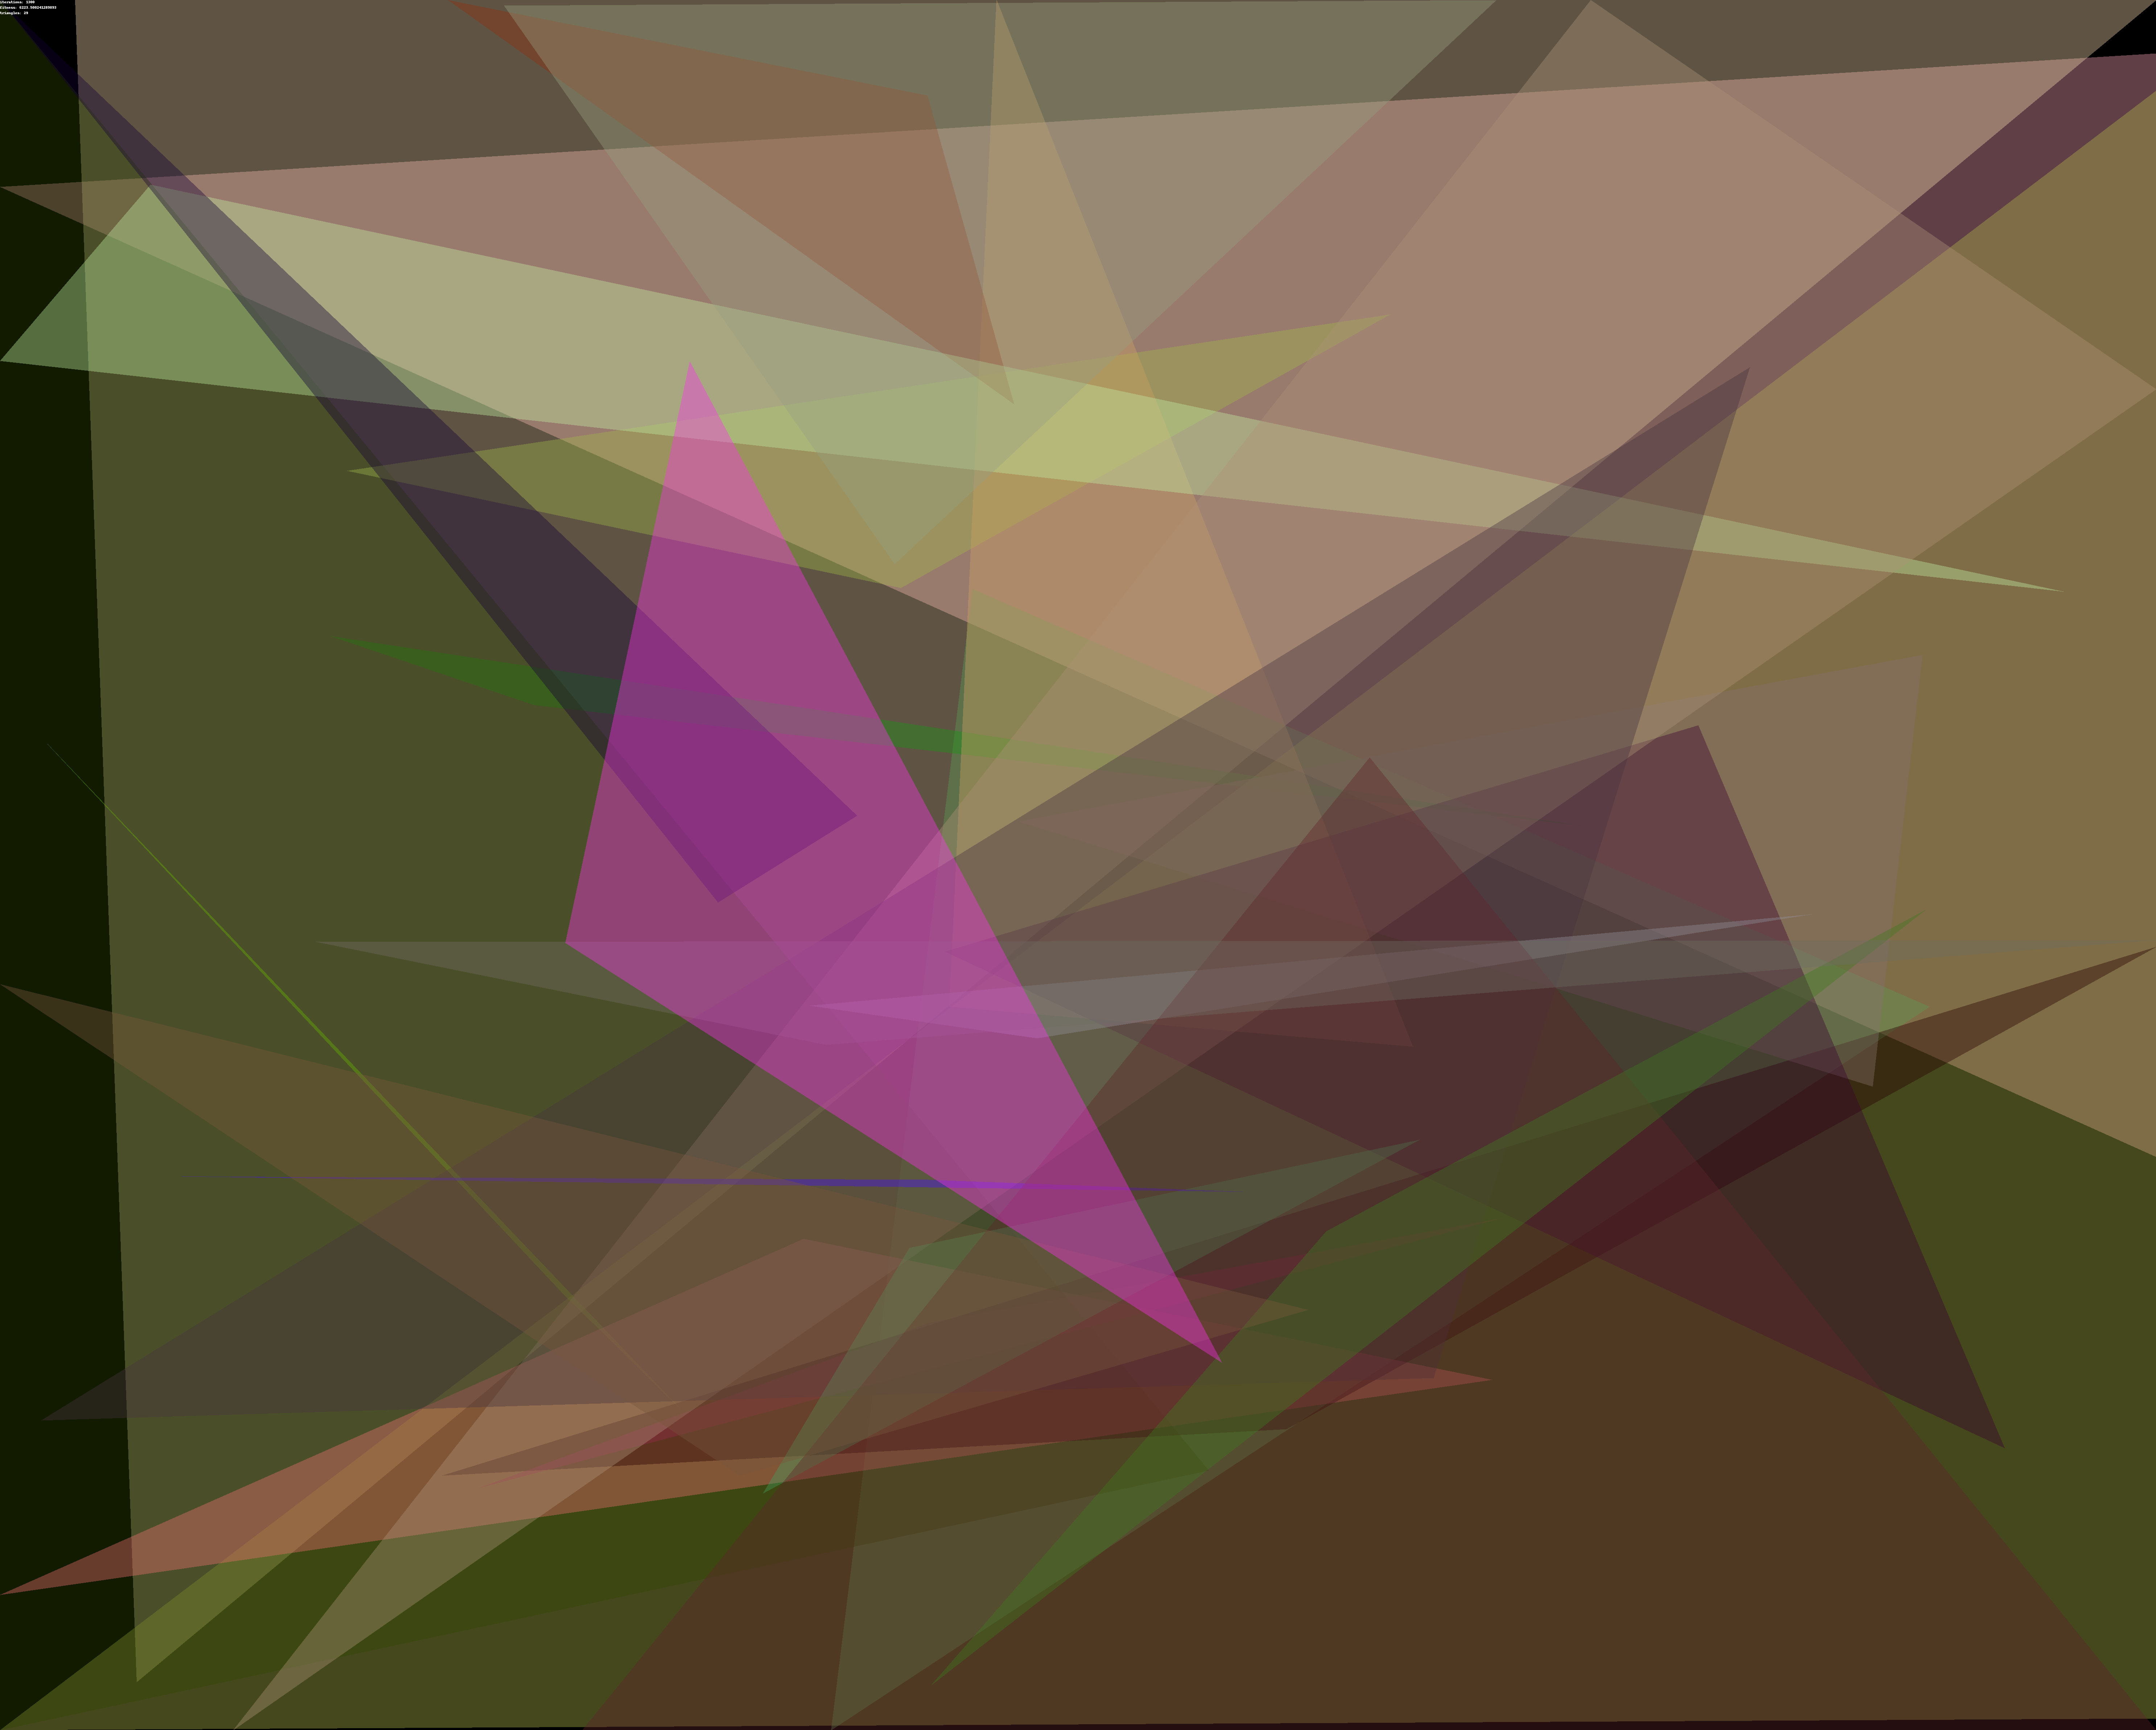

t: 1400 fitness: 5635.627404482867 triangles: 31


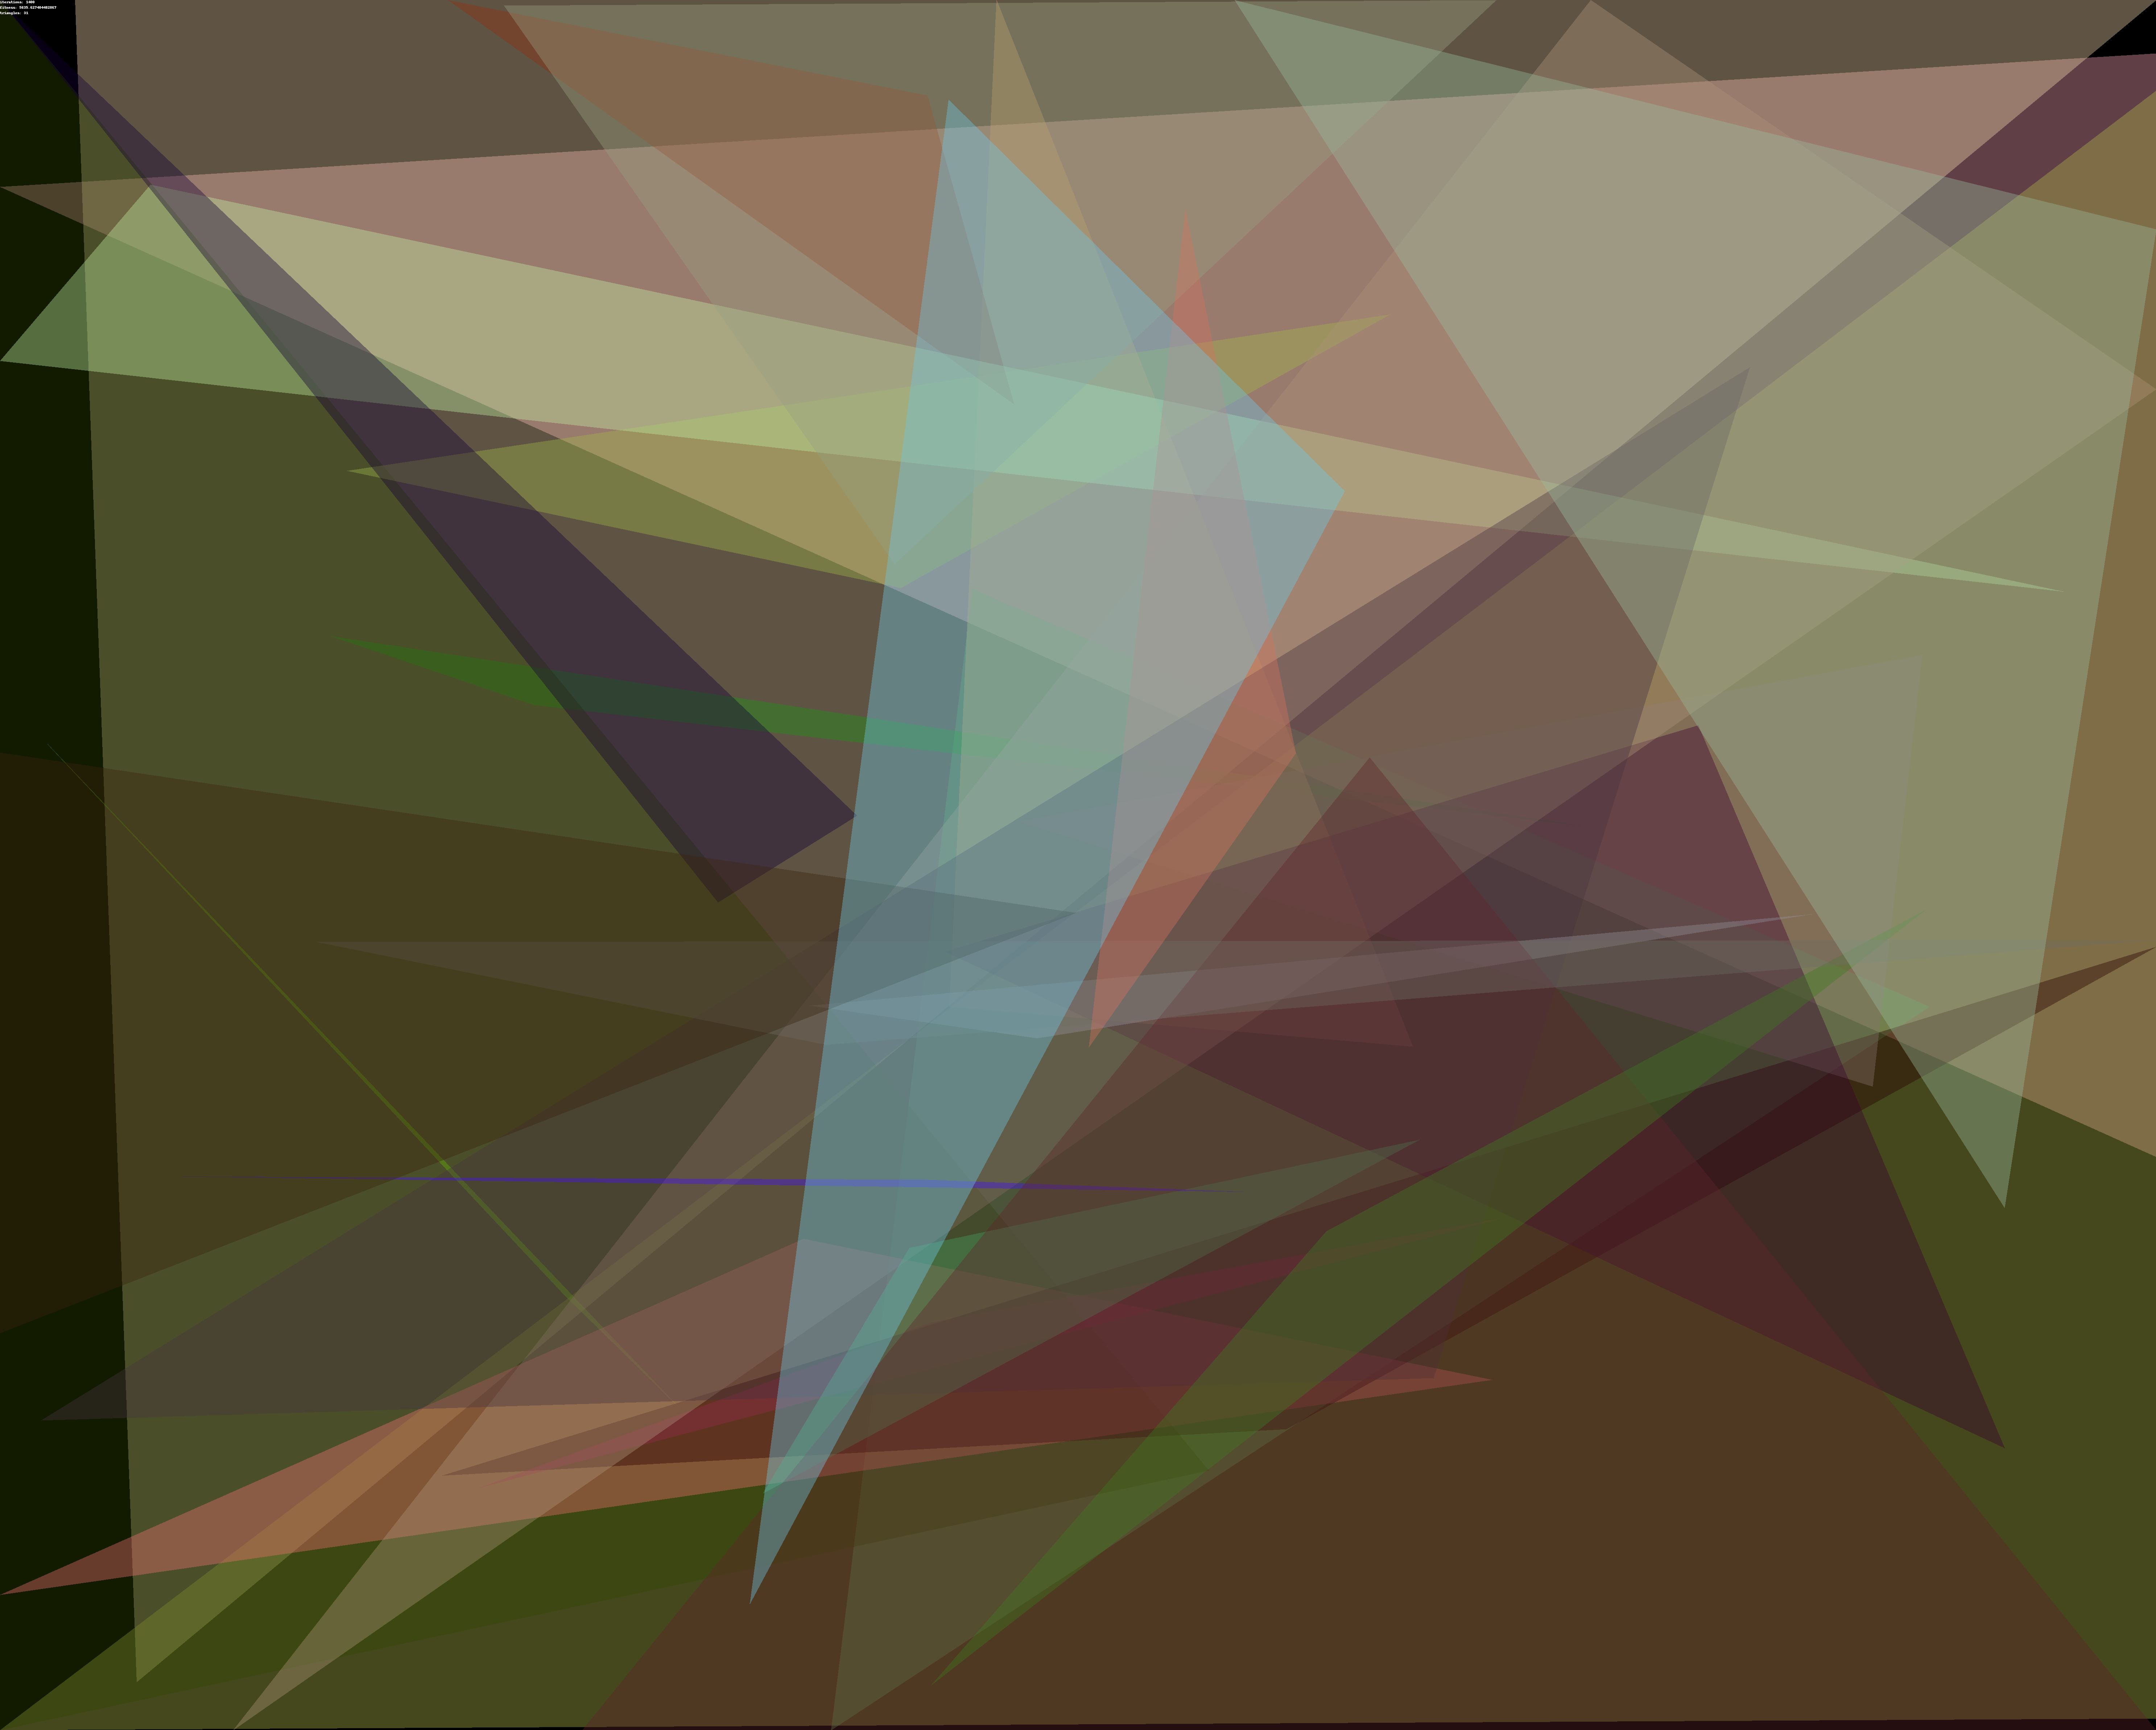

t: 1500 fitness: 5477.151052831171 triangles: 33


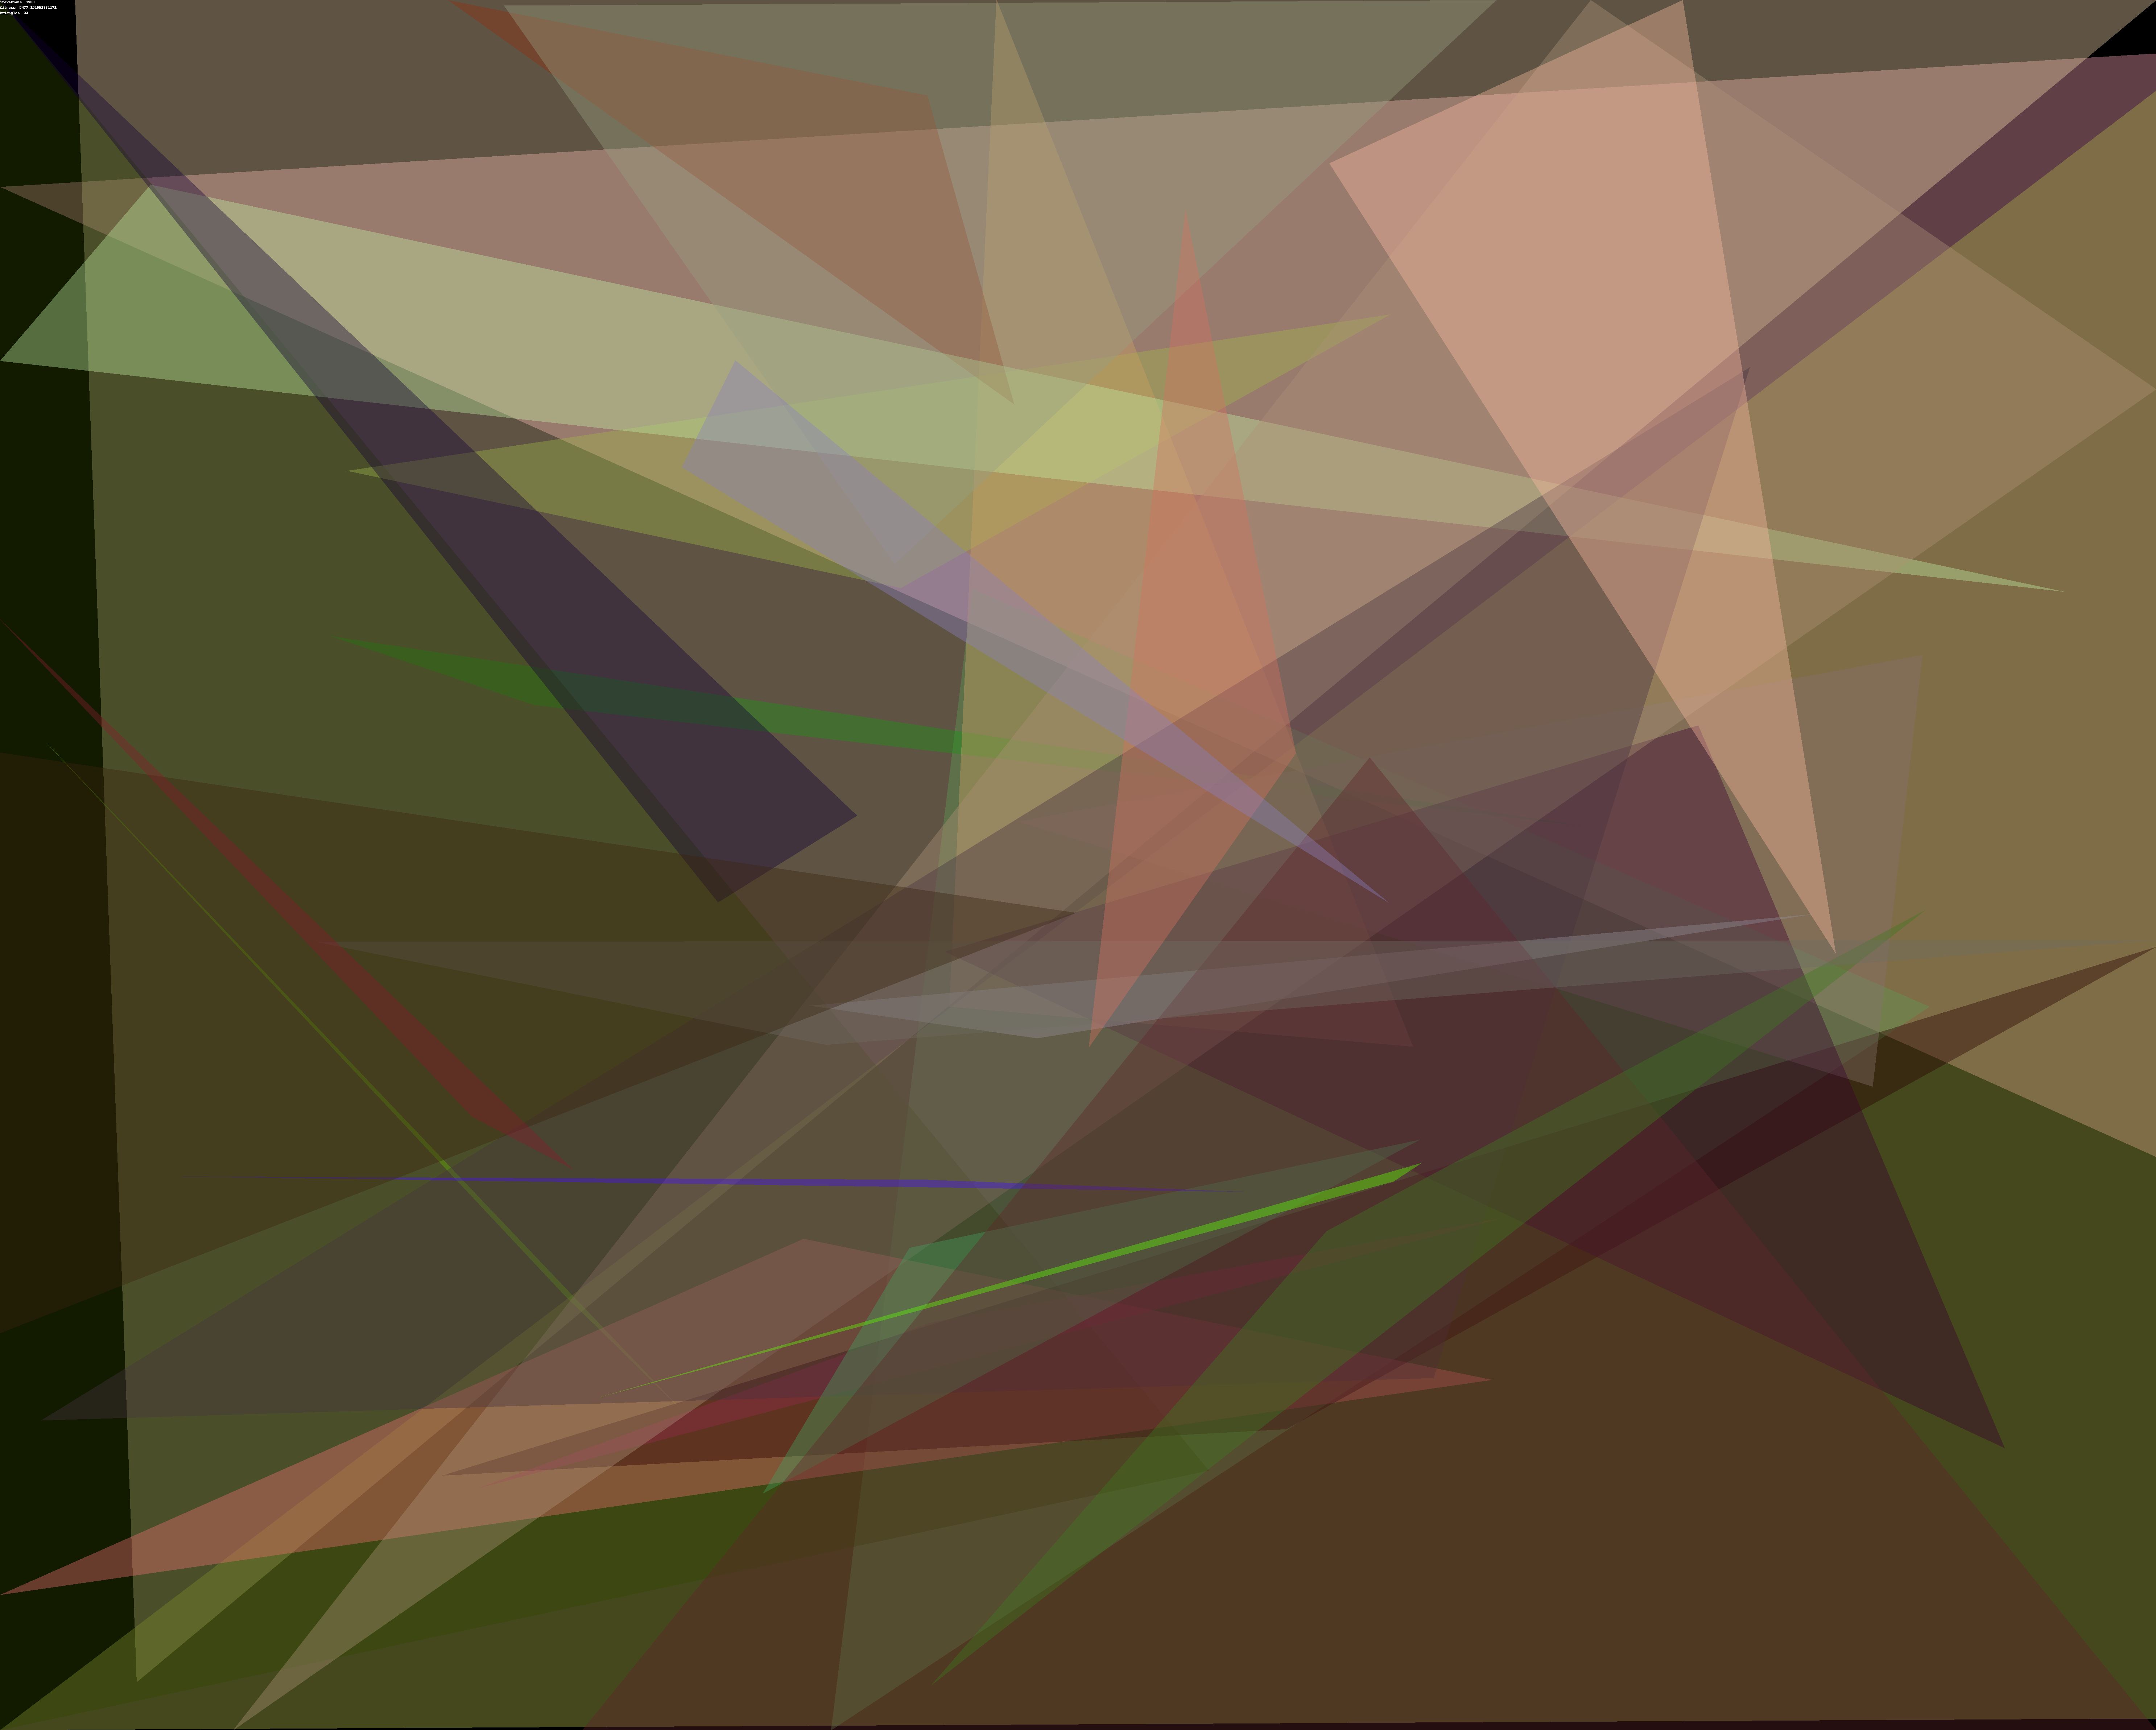

t: 1600 fitness: 5661.747400361374 triangles: 35


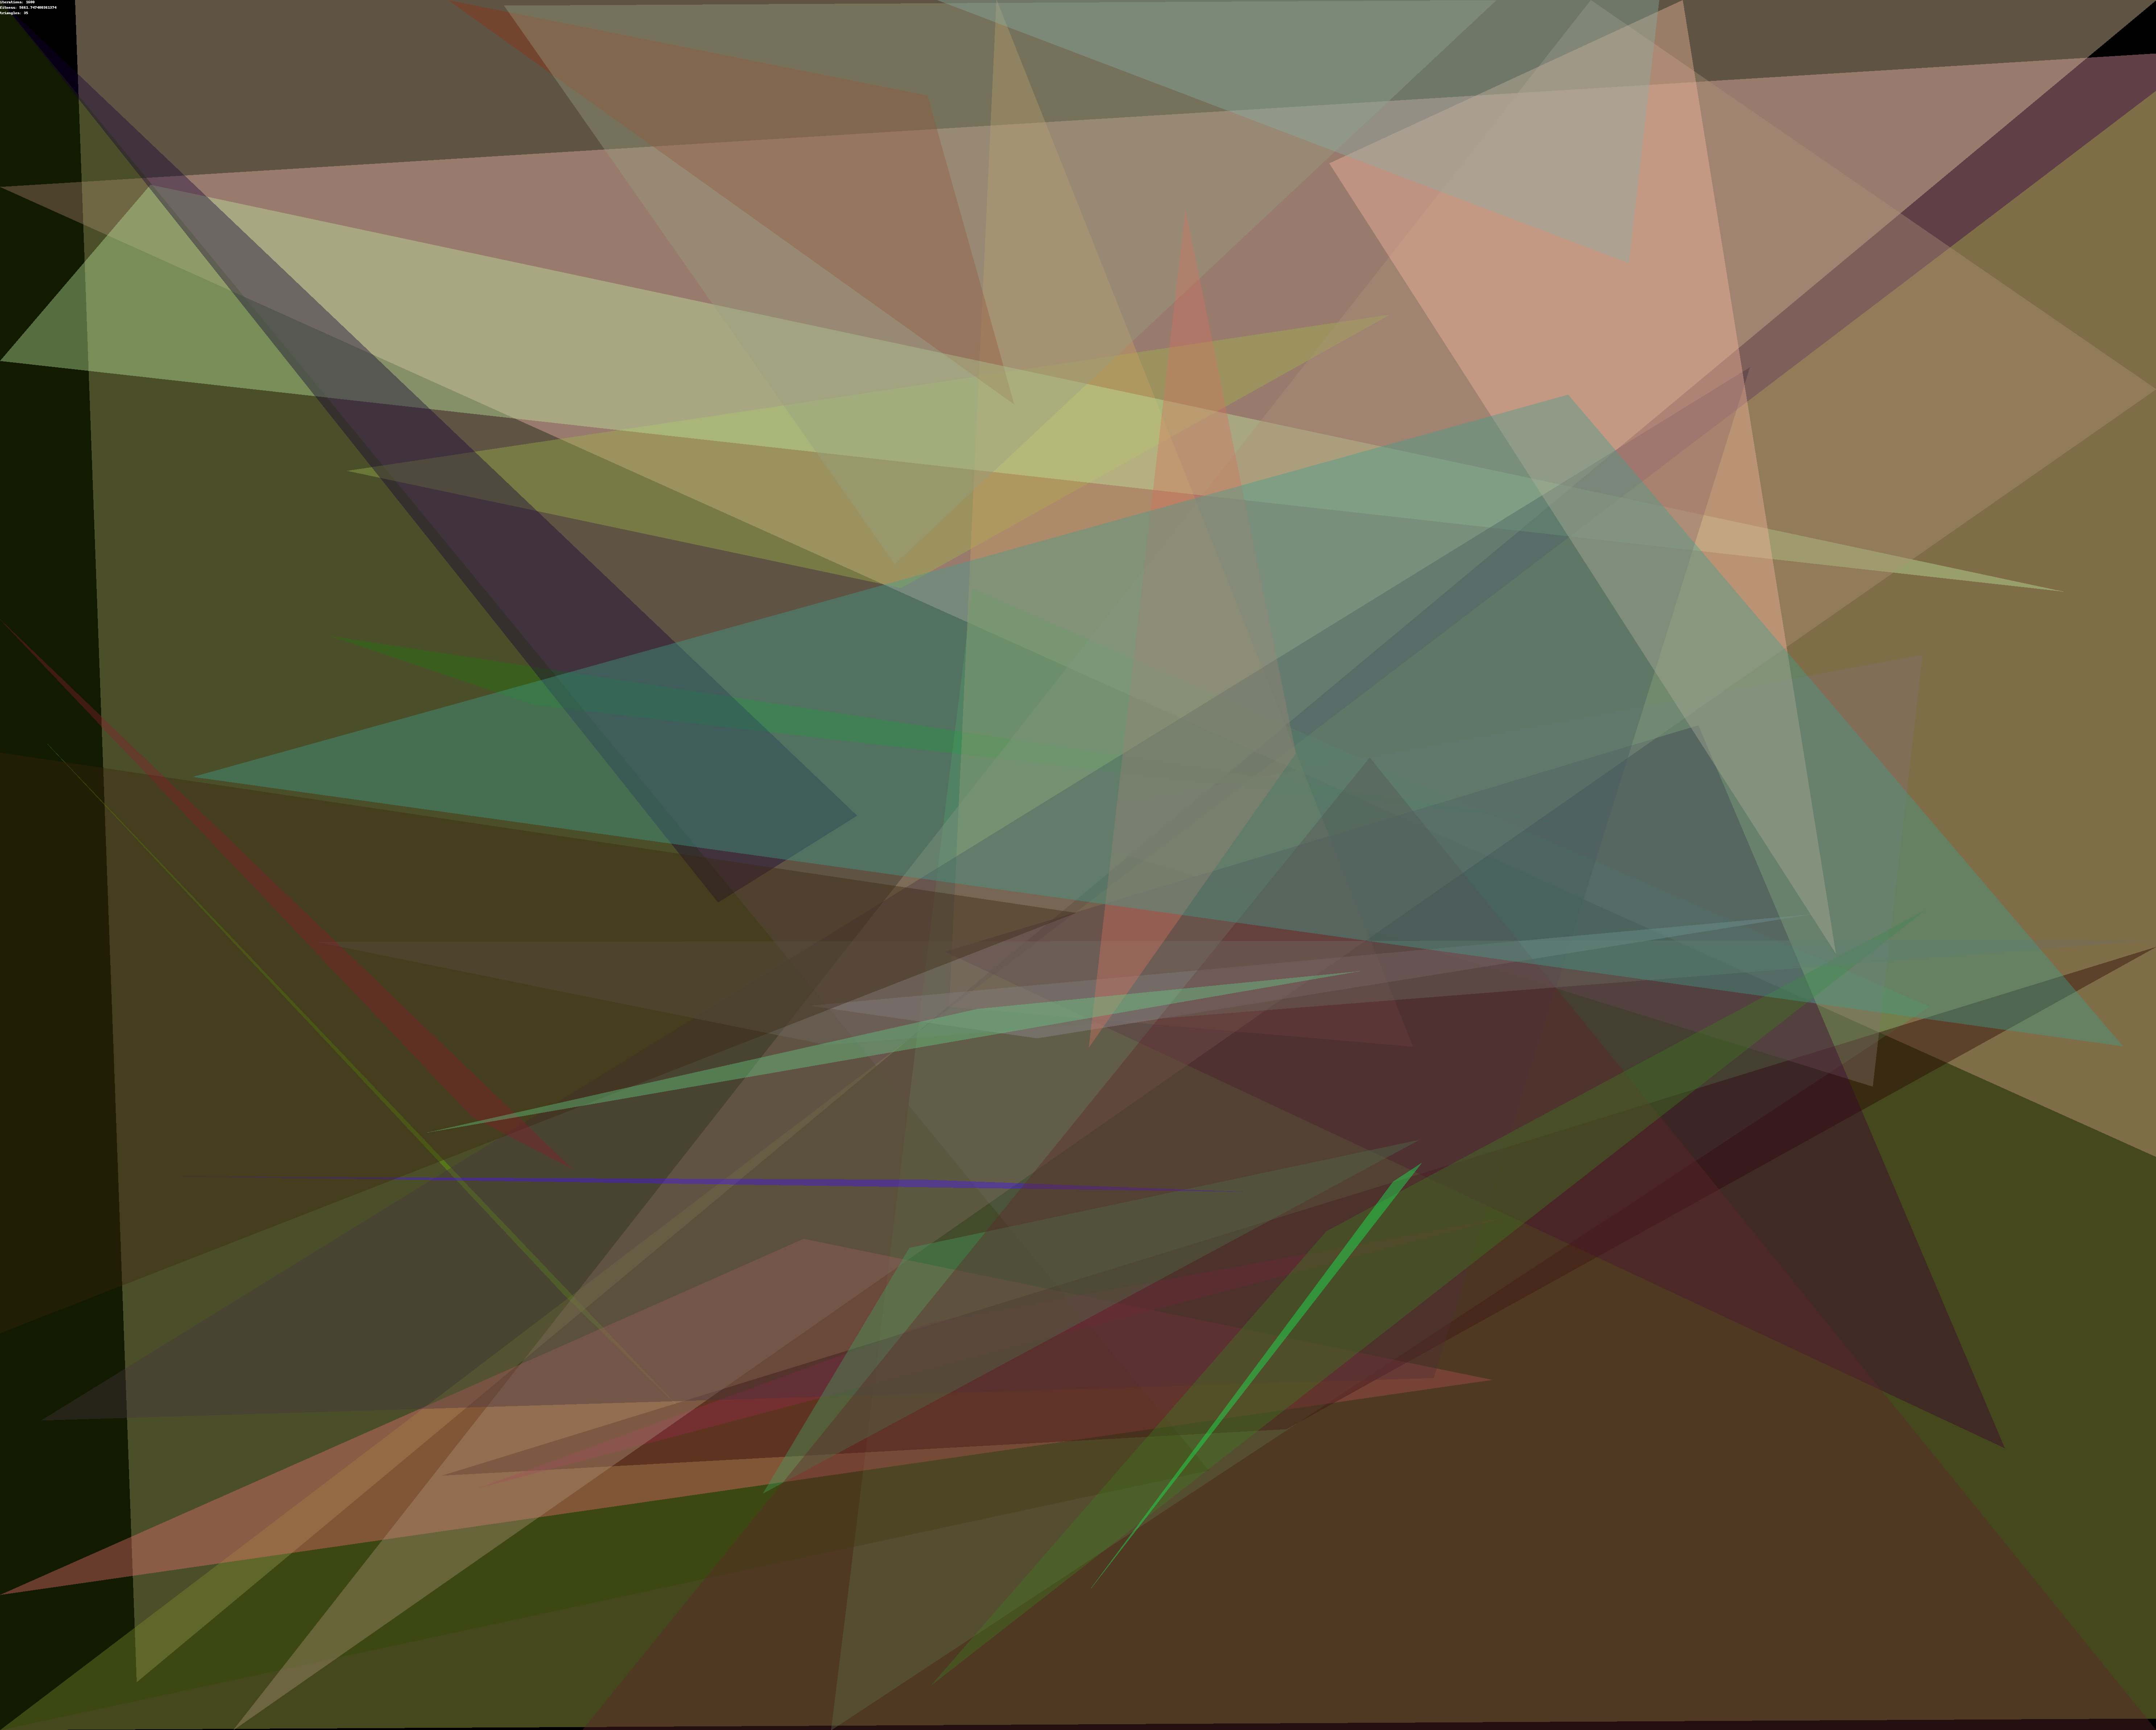

t: 1700 fitness: 5485.510329181455 triangles: 37


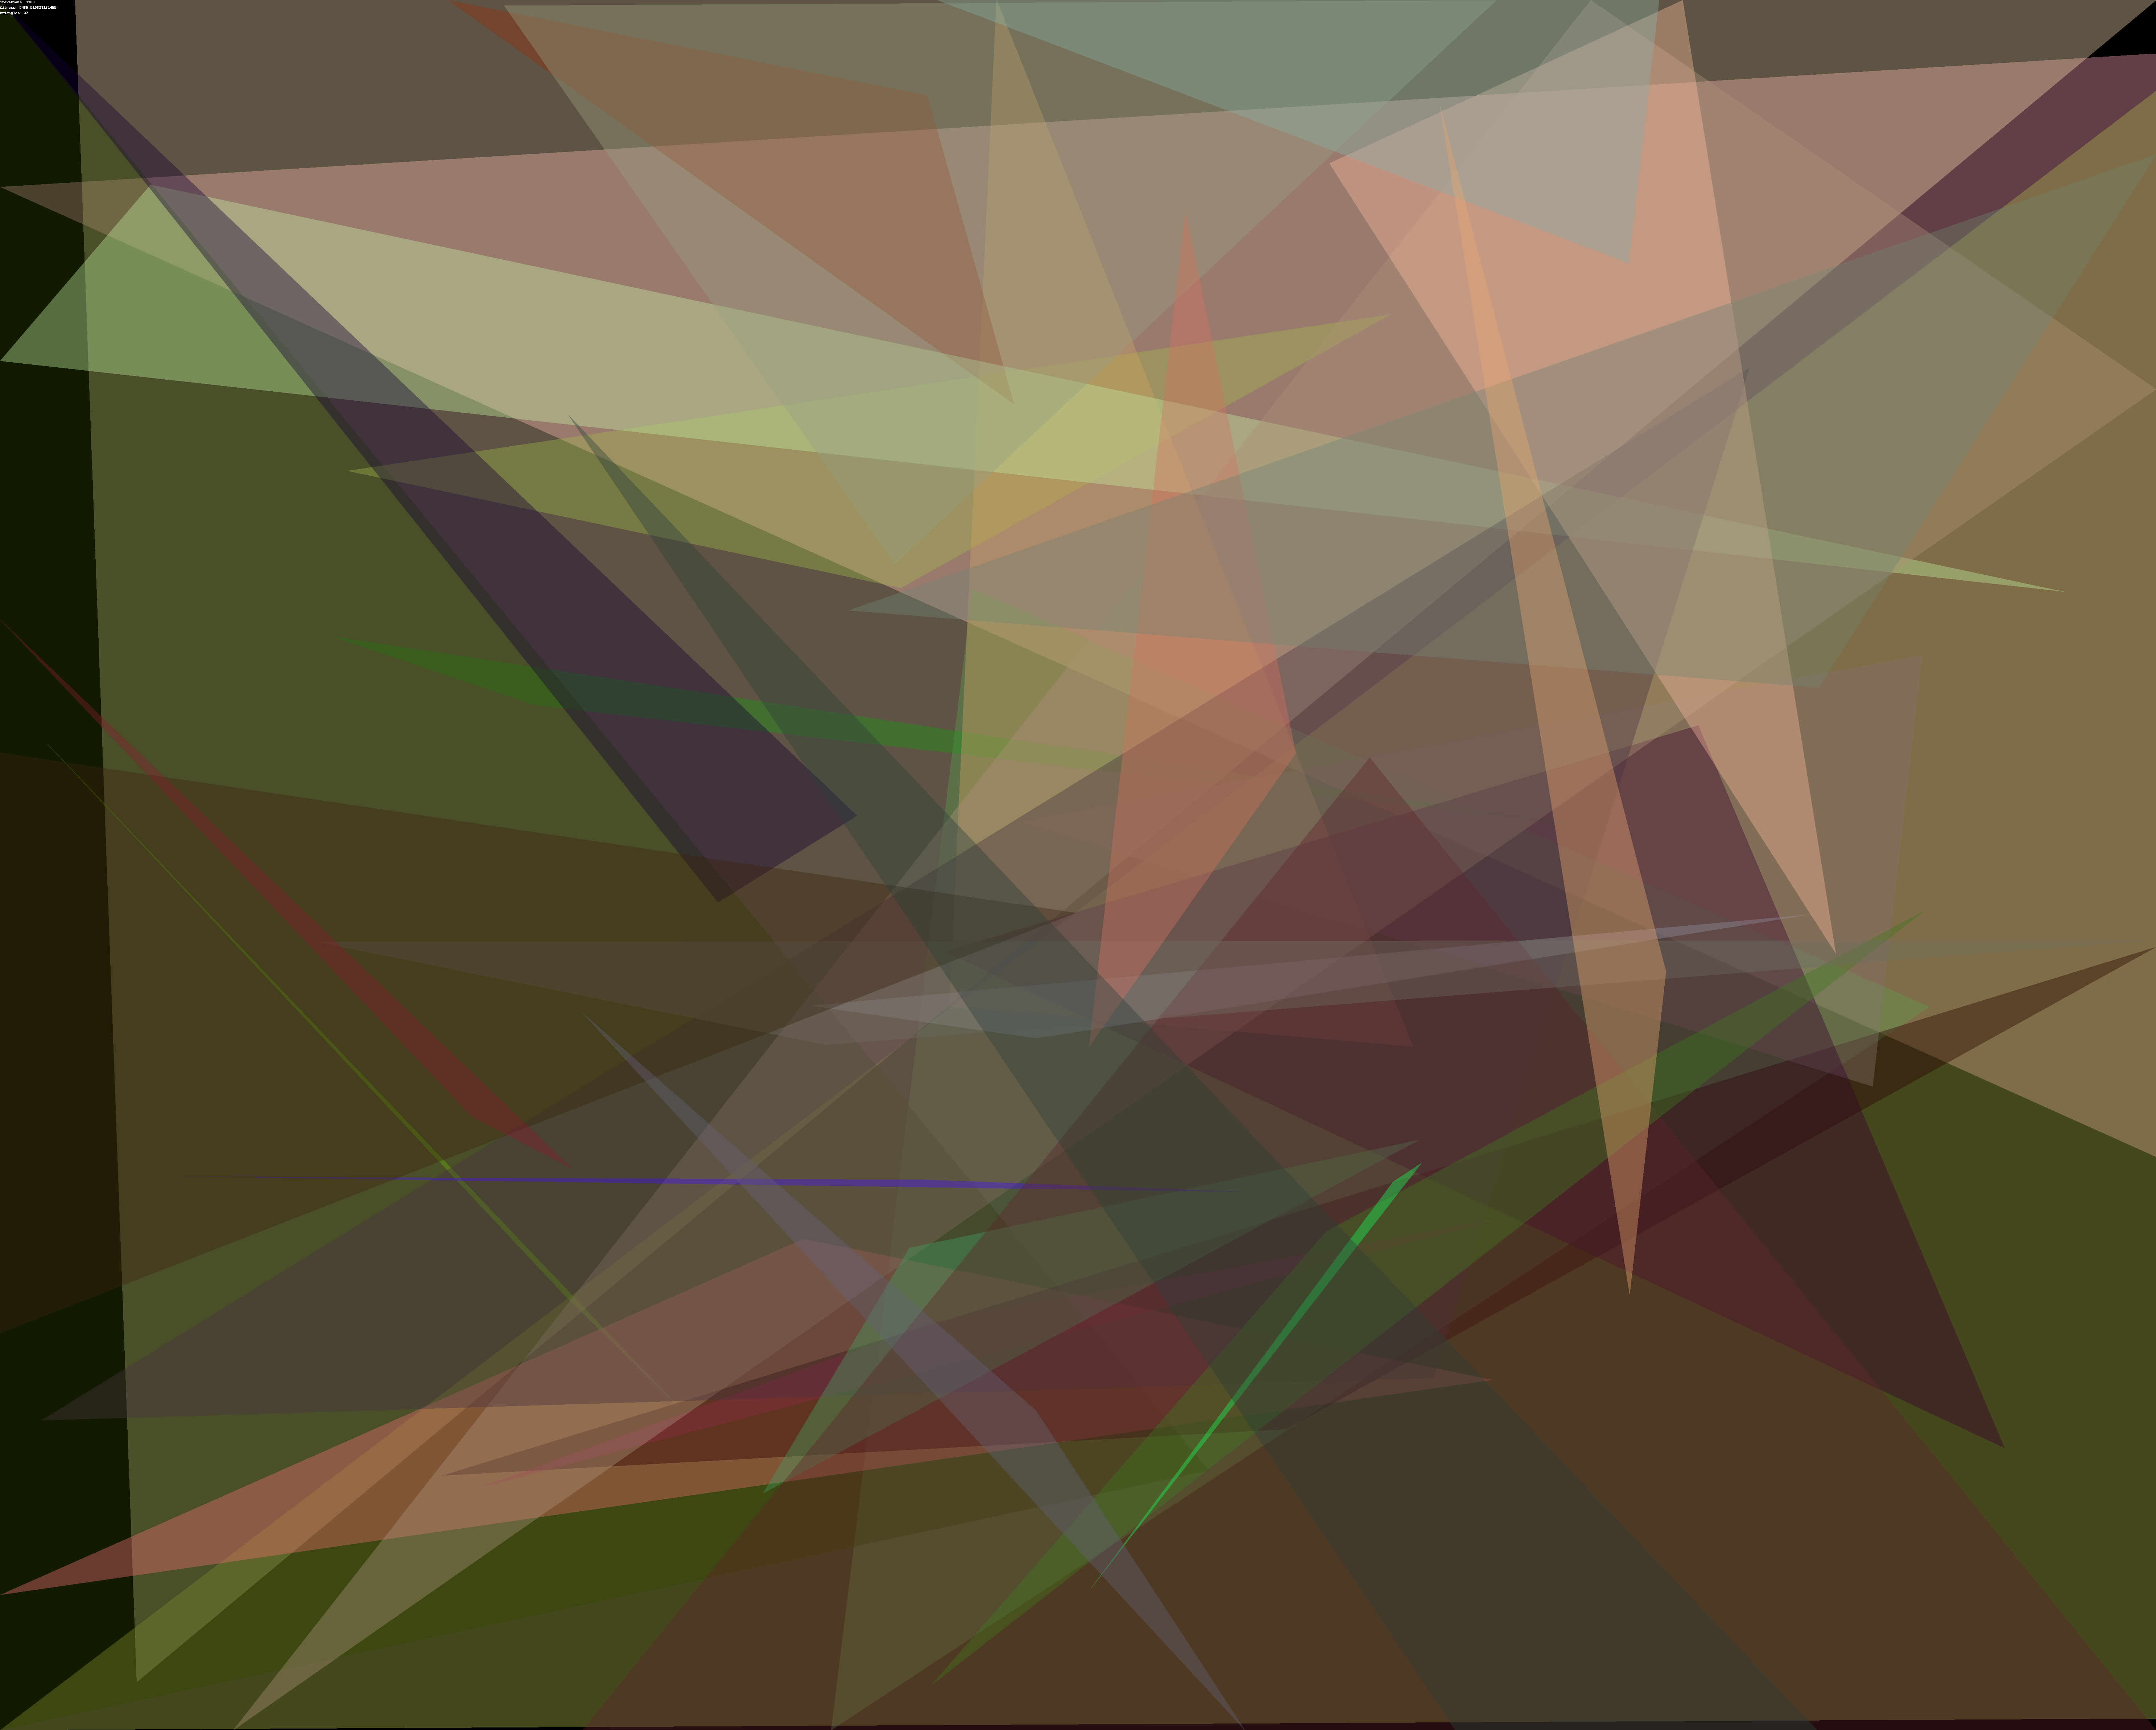

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paint(N=5, img='./liberty.jpg', output_file_name='liberty', T=10000, N_offspring=2, max_obj_num=500, device=device)